*Основная задача*: Зарегистрируйтесь на платформе Kaggle и скачайте набор данных, и по образцу создайте нейронную сеть. Выведите матрицу ошибок и постарайтесь минимизировать их, подобрав параметры нейронной сети.

In [1]:
import numpy as np # Подключаем библиотеку numpy
import pandas as pd # Библиотека pandas
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import  RandomizedSearchCV

from tensorflow import keras
from keras.models import Sequential # Подлючаем класс создания модели Sequential
from keras.layers import Dense, Dropout, Flatten, MaxPooling1D # Подключаем класс Dense - полносвязный слой, и Flatten - данные выстраиваем в линию, одномерные
from keras.optimizers import Adam # Подключаем оптимизатор Adam
from keras import utils #Утилиты для to_categorical
from keras.utils import plot_model

*1. Загрузите данные с площадки Kaggle.*

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/W1llAnn/1tdata-homework/main/3.1pima-indians-diabetes.csv', delimiter=',')
df.head()

,6,148,72,35,0,33.6,0.627,50,1
0,1,85,66,29,0,26.6,0.351,31,0
1,8,183,64,0,0,23.3,0.672,32,1
2,1,89,66,23,94,28.1,0.167,21,0
3,0,137,40,35,168,43.1,2.288,33,1
4,5,116,74,0,0,25.6,0.201,30,0


In [3]:
df.shape

(767, 9)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 767 entries, 0 to 766
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   6       767 non-null    int64  
 1   148     767 non-null    int64  
 2   72      767 non-null    int64  
 3   35      767 non-null    int64  
 4   0       767 non-null    int64  
 5   33.6    767 non-null    float64
 6   0.627   767 non-null    float64
 7   50      767 non-null    int64  
 8   1       767 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [5]:
df.isnull().sum()

6        0
148      0
72       0
35       0
0        0
33.6     0
0.627    0
50       0
1        0
dtype: int64

**Всего 767 строк и 9 колонок, пропусков нет.**

*2. Подготавливаем данные (приводим их к нужным типам данных, проводим базовое EDA, делаем выводы, если возможно).*

Колонки зашифрованы следующим образом:
*   6 - pregnancies - беременность
*   148 - glucose - глюкоза
*   72 - blood_pressure - кровяное давление
*   35 - skin_thickness - толщина кожи
*   0 - insulin - инсулин
*   33.6 - bmi - индекс массы тела
*   0.627 - diabetes_pedigree_function - диабет у родственников (наследственность)
*   50 - age - возраст
*   1 - class - есть диабет или нет

Я изменю колонки для большей "читаемости"

In [6]:
df = df.rename(columns={
    '6': 'pregnancies', 
    '148': 'glucose',
    '72': 'blood_pressure',
    '35': 'skin_thickness',
    '0': 'insulin',
    '33.6': 'bmi',
    '0.627': 'diabetes_pedigree_function',
    '50': 'age',
    '1': 'class',
    })

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 767 entries, 0 to 766
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   pregnancies                 767 non-null    int64  
 1   glucose                     767 non-null    int64  
 2   blood_pressure              767 non-null    int64  
 3   skin_thickness              767 non-null    int64  
 4   insulin                     767 non-null    int64  
 5   bmi                         767 non-null    float64
 6   diabetes_pedigree_function  767 non-null    float64
 7   age                         767 non-null    int64  
 8   class                       767 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


**Все данные имеют тип int64 или float64, никаких преобразований на этом этапе не требуется.**

In [8]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
pregnancies,767.0,3.842243,3.370877,0.000,1.0000,3.000,6.000,17.00
glucose,767.0,120.859192,31.978468,0.000,99.0000,117.000,140.000,199.00
blood_pressure,767.0,69.101695,19.368155,0.000,62.0000,72.000,80.000,122.00
skin_thickness,767.0,20.517601,15.954059,0.000,0.0000,23.000,32.000,99.00
insulin,767.0,79.903520,115.283105,0.000,0.0000,32.000,127.500,846.00
bmi,767.0,31.990482,7.889091,0.000,27.3000,32.000,36.600,67.10
diabetes_pedigree_function,767.0,0.471674,0.331497,0.078,0.2435,0.371,0.625,2.42
age,767.0,33.219035,11.752296,21.000,24.0000,29.000,41.000,81.00
class,767.0,0.348110,0.476682,0.000,0.0000,0.000,1.000,1.00


array([[<Axes: title={'center': 'pregnancies'}>,
        <Axes: title={'center': 'glucose'}>,
        <Axes: title={'center': 'blood_pressure'}>],
       [<Axes: title={'center': 'skin_thickness'}>,
        <Axes: title={'center': 'insulin'}>,
        <Axes: title={'center': 'bmi'}>],
       [<Axes: title={'center': 'diabetes_pedigree_function'}>,
        <Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'class'}>]], dtype=object)

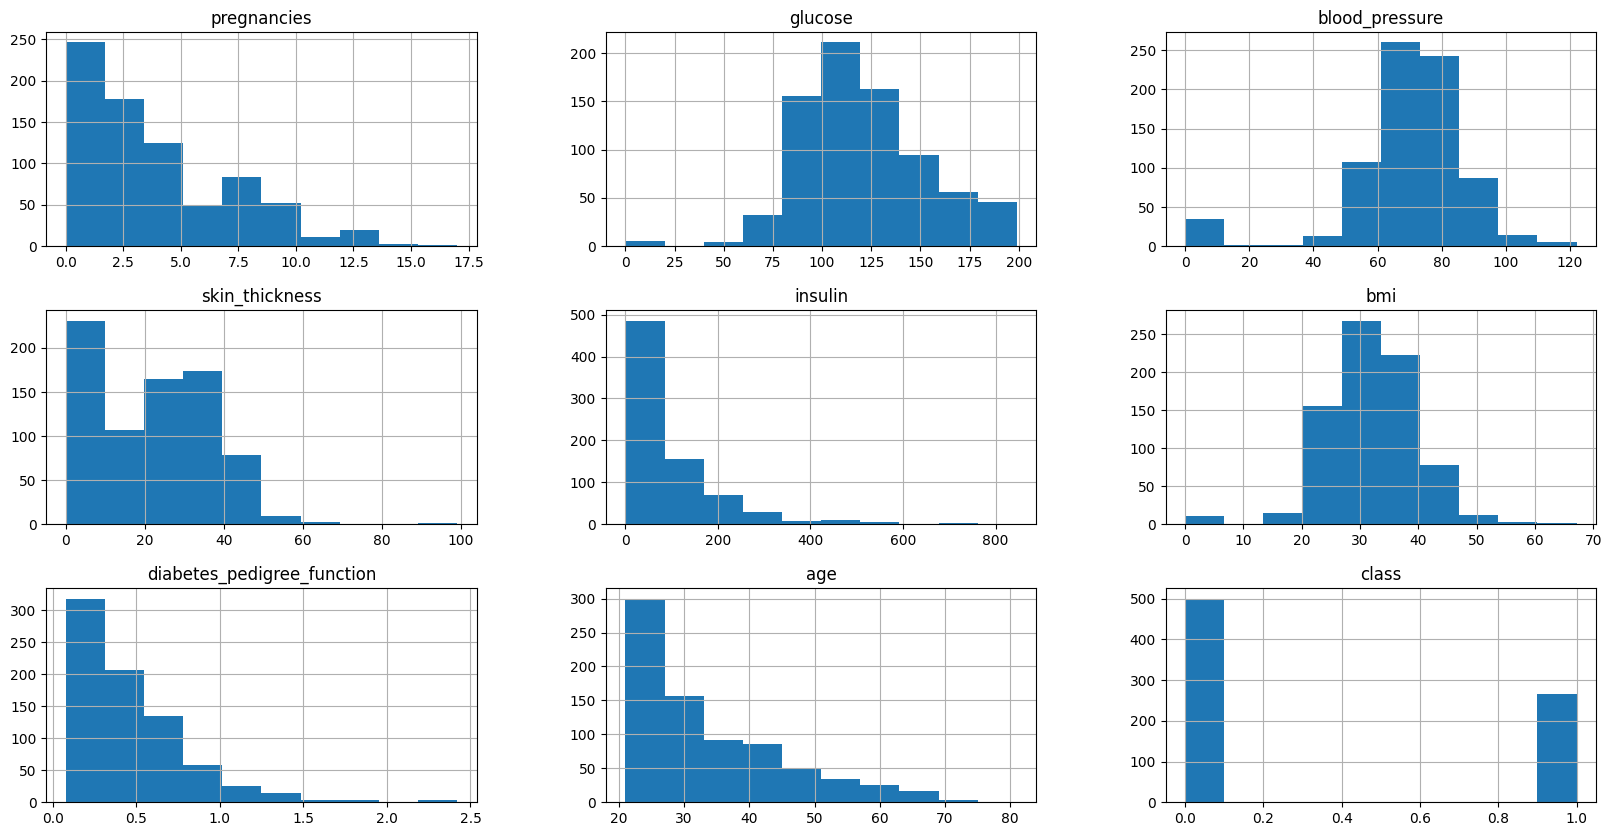

In [9]:
df.hist(figsize=(20,10))

Что мы можем сказать, посмотрев на гистограммы:
*   pregnancies - у большинства выборки было от 0 до 5 беременностей. В среднем 3.8
*   glucose - уровень глюкозы у большинства от 60 до 130. В среднем 120.86
*   blood_pressure - кровяное давление у большинства от 60 до 90. В среднем 69.1
*   skin_thickness - толщина кожи у большинства от 0 до 40. В среднем 20.5
*   insulin - инсулин у большинства выборки от 0 до 120. В среднем 79.9
*   bmi - инвекс массы тела у большинства от 20 до 45. В среднем 32
*   diabetes_pedigree_function - наследственность диабета у большинства от 0 до 1. В среднем 0.47
*   age - возраст по выборке у большинства от 20 до 40. В среднем 33.22
*   class - больше половины выборки имеет класс 0, т.е. диабет отсутствует

In [10]:
dataset = df.values
X = dataset[: , 0:8].astype(float)
Y = dataset[:,8]
Y = Y.astype(int)
print(X.shape)
print(Y.shape)
print(Y)

(767, 8)
(767,)
[0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 0 1 0 0 1 1 1 1 1 0 0 0 0 1 0 0 0 0 0 1
 1 1 0 0 0 1 0 1 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 1 0 1 0 0 0 1 0 1 0 0
 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 1 1
 0 0 1 1 1 0 0 0 1 0 0 0 1 1 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 1 0 1 1 0 0 0 1 0 0 0 0 1 1 0 0 0 0 1 1 0 0 0 1 0 1 0 1 0 0 0 0 0 1
 1 1 1 1 0 0 1 1 0 1 0 1 1 1 0 0 0 0 0 0 1 1 0 1 0 0 0 1 1 1 1 0 1 1 1 1 0
 0 0 0 0 1 0 0 1 1 0 0 0 1 1 1 1 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 1
 0 1 0 0 1 0 1 0 0 1 1 0 0 0 0 0 1 0 0 0 1 0 0 1 1 0 0 1 0 0 0 1 1 1 0 0 1
 0 1 0 1 1 0 1 0 0 1 0 1 1 0 0 1 0 1 0 0 1 0 1 0 1 1 1 0 0 1 0 1 0 0 0 1 0
 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 1 0 1 1 0 0 1 0 0 1 0 0 1 1
 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 1 1 0 0 1 0 0 1 0 0 1 0 1 1 0 1 0 1 0 1 0
 1 1 0 0 0 0 1 1 0 1 0 1 0 0 0 0 1 1 0 1 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 1 1
 1 0 0 1 0 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0
 0 0 1 1 

**Но классы у нас не сбалансированы, поэтому зададим веса:**

In [11]:
counts = np.bincount(Y)
print('Кол-во 0 класса:', counts[0], 'Кол-во 1 класса:', counts[1])

weight_for_0 = 1.0 / counts[0]
weight_for_1 = 1.0 / counts[1]
print('Веса для 0 класса:', weight_for_0, ' . Веса для 0 класса:', weight_for_1)

Кол-во 0 класса: 500 Кол-во 1 класса: 267
Веса для 0 класса: 0.002  . Веса для 0 класса: 0.003745318352059925


**Этими весами я воспользуюсь чуть позже**

*3. Создаем тренировочную и валидационную выборки.*

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, stratify=Y, test_size=0.20, random_state=42)

*4. Масштабируем данные известными вам методами из библиотеки Scikit-learn.*

In [13]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaler = scaler.transform(X_train)
X_test_scaler = scaler.transform(X_test)

*5. Создайте функцию, при вызове которой будет собираться и компилироваться (model.compile) архитектура модели. Функция должна возвращать собранную архитектуру. Параметры слоев и их количество вы выбираете сами, стараясь добиться наилучшего качества.*

In [14]:
def baseline_model():
    # create model
    hid_size = 128

    model = Sequential([
        keras.layers.Dense(hid_size, activation='relu', input_dim=8),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(hid_size, activation='relu'),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(1, activation='sigmoid')
    ])

    # Compile model
    model.compile(
        optimizer=Adam(),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

model = baseline_model()

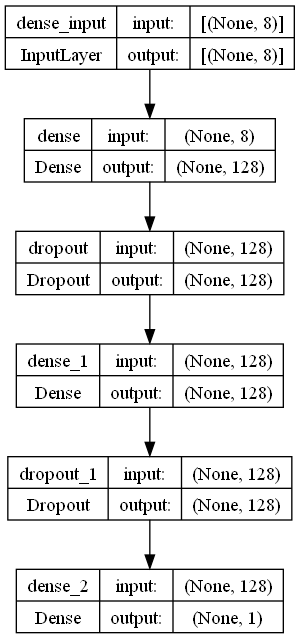

In [15]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [16]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               1152      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 17793 (69.50 KB)
Trainable params: 17793 (69.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


*6. Обучите модель.*

In [17]:
callbacks = keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.90,
    patience=100,
    verbose=1,
    mode='auto',
    baseline=None,
    )

class_weight = {0: weight_for_0 , 1:weight_for_1}


In [18]:
model_fit = model.fit(
    X_train_scaler,
    y_train,
    batch_size=64,
    epochs=100,
    verbose=1,
    callbacks=callbacks,
    validation_data=(X_test_scaler , y_test),
    class_weight=class_weight,
)

Epoch 1/100
10/10 [==============================] - 1s 22ms/step - loss: 0.0018 - accuracy: 0.6150 - val_loss: 0.6390 - val_accuracy: 0.6818
Epoch 2/100
10/10 [==============================] - 0s 5ms/step - loss: 0.0015 - accuracy: 0.7064 - val_loss: 0.6028 - val_accuracy: 0.6948
Epoch 3/100
10/10 [==============================] - 0s 5ms/step - loss: 0.0014 - accuracy: 0.7423 - val_loss: 0.5777 - val_accuracy: 0.7078
Epoch 4/100
10/10 [==============================] - 0s 5ms/step - loss: 0.0013 - accuracy: 0.7520 - val_loss: 0.5607 - val_accuracy: 0.7078
Epoch 5/100
10/10 [==============================] - 0s 5ms/step - loss: 0.0013 - accuracy: 0.7390 - val_loss: 0.5467 - val_accuracy: 0.7013
Epoch 6/100
10/10 [==============================] - 0s 6ms/step - loss: 0.0013 - accuracy: 0.7830 - val_loss: 0.5436 - val_accuracy: 0.7013
Epoch 7/100
10/10 [==============================] - 0s 6ms/step - loss: 0.0013 - accuracy: 0.7586 - val_loss: 0.5541 - val_accuracy: 0.7143
Epoch 8/100


*7. Оцените качество модели по выбранной вами метрике (выбор метрики должен быть обоснован).*

binary_crossentropy и accuracy стандартные метрики для задач бинарной классификации.

Модель явно переобучена, посмотрим classification_report

In [19]:
pred_train = np.round(model.predict(X_train_scaler, verbose=1))
print(classification_report(y_train, pred_train))

20/20 [==============================] - 0s 947us/step
              precision    recall  f1-score   support

           0       0.93      0.87      0.90       400
           1       0.78      0.87      0.82       213

    accuracy                           0.87       613
   macro avg       0.85      0.87      0.86       613
weighted avg       0.88      0.87      0.87       613



In [20]:
pred_test = np.round(model.predict(X_test_scaler, verbose=1))
print(classification_report(y_test, pred_test))

5/5 [==============================] - 0s 999us/step


              precision    recall  f1-score   support

           0       0.81      0.70      0.75       100
           1       0.56      0.70      0.62        54

    accuracy                           0.70       154
   macro avg       0.69      0.70      0.69       154
weighted avg       0.72      0.70      0.71       154



При сравнении значений метрик наглядно видно, что accuracy на тренировочной выше, чем на тестовой, но это мы видели и в callbacks выше.
Да и в целом, все показатели на тестовой ниже, чем на тренировочной

*8. Постройте графики точности и графики ошибки в зависимости от количества эпох для тренировочной выборки и для валидационной.*

In [21]:
print(model_fit.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


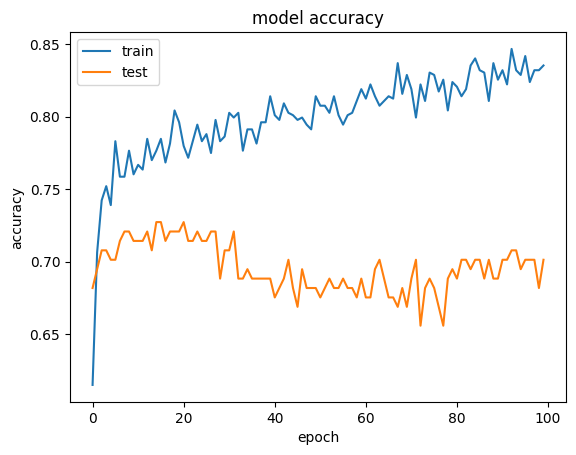

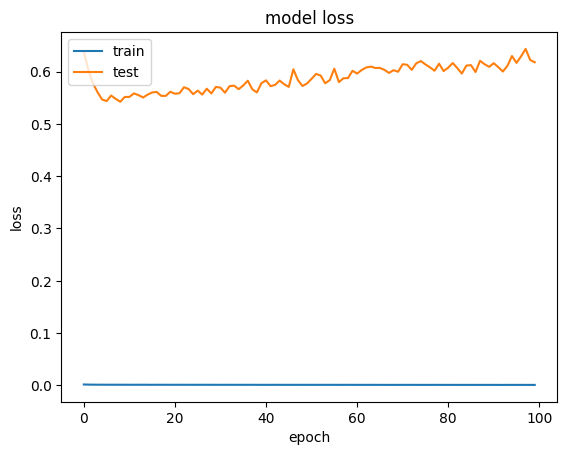

In [22]:
plt.plot(model_fit.history['accuracy'])
plt.plot(model_fit.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(model_fit.history['loss'])
plt.plot(model_fit.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**Качество модели на тестовой выборке по метрике accuracy не приростает, в то время как на тренировочной росло.**

*9. Постройте матрицу ошибок для валидационной выборки.*

In [23]:
r = confusion_matrix(y_test, pred_test)
print(r)

[[70 30]
 [16 38]]


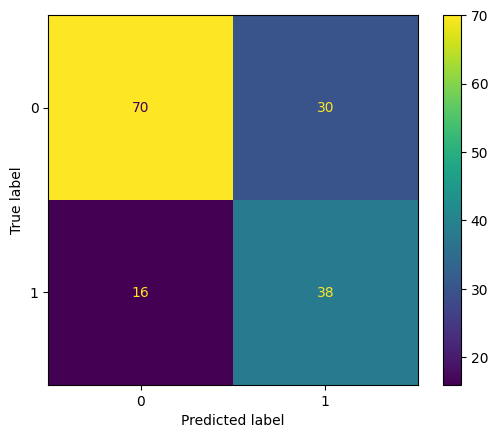

In [24]:
disp = ConfusionMatrixDisplay(confusion_matrix=r)
disp.plot()
plt.show()

Наша модель совершила 30 ошибок при определении 0 класса и 16 при определении 1 класса

**ВЫВОД:  Модель показала себя хорошо на тренировочной выборке и хуже на тестовой, поэтому мы можем говорить о переобучении. Так же из графиков мы видим, что качество (accuracy) на тестовой выборке не приростало. В итоге, модель совершила суммарно 46 ошибок из 154 примеров, что примерно 30%. Далее мы будем подбирать оптимальные параметры в задании ПРО.**

# ЗАДАНИЕ ПРО (Не обязательно к выполнению):
Оптимизируйте параметры модели в автоматическом режиме. Можно использовать алгоритмы оптимизации типа GridSearch, но не сильно увлекаясь — иначе расчёт может быть излишне долог.

*1. Установите библиотеку scikeras, либо найдите как импортировать модуль KerasRegressor в tensorflow.*

*2. Из этой же библиотеки scikeras импортируйте модуль KerasRegressor (найдите в документации как его импортировать).*

In [25]:
from scikeras.wrappers import KerasClassifier, KerasRegressor

*3. Поместите вашу модель в оболочку KerasRegressor.*

*4. Подберите оптимальные параметры для модели с помощью GridSearchCV или RandomizedSearchCV.*

In [33]:
model_regressor = KerasClassifier(build_fn=baseline_model, class_weight=class_weight)
optimizers = ['adam', 'rmsprop']
epochs = np.array([20, 30, 40, 50, 60])
batches = np.array([8, 16, 32, 64, 128, 256, 512, 1024])

param_grid = dict(optimizer=optimizers, epochs=epochs, batch_size=batches)
random_search = RandomizedSearchCV(estimator=model_regressor, 
                                   param_distributions=param_grid)
random_search.fit(X_train_scaler, y_train)

Epoch 1/20


c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


1/1 [==============================] - 1s 844ms/step - loss: 0.0019 - accuracy: 0.5531
Epoch 2/20
1/1 [==============================] - 0s 5ms/step - loss: 0.0018 - accuracy: 0.6020
Epoch 3/20
1/1 [==============================] - 0s 9ms/step - loss: 0.0018 - accuracy: 0.5959
Epoch 4/20
1/1 [==============================] - 0s 7ms/step - loss: 0.0017 - accuracy: 0.6694
Epoch 5/20
1/1 [==============================] - 0s 9ms/step - loss: 0.0017 - accuracy: 0.6265
Epoch 6/20
1/1 [==============================] - 0s 9ms/step - loss: 0.0017 - accuracy: 0.6510
Epoch 7/20
1/1 [==============================] - 0s 10ms/step - loss: 0.0016 - accuracy: 0.6184
Epoch 8/20
1/1 [==============================] - 0s 7ms/step - loss: 0.0016 - accuracy: 0.6653
Epoch 9/20
1/1 [==============================] - 0s 8ms/step - loss: 0.0016 - accuracy: 0.6714
Epoch 10/20
1/1 [==============================] - 0s 8ms/step - loss: 0.0016 - accuracy: 0.6735
Epoch 11/20
1/1 [==============================

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


1/1 [==============================] - 1s 801ms/step - loss: 0.0019 - accuracy: 0.4122
Epoch 2/20
1/1 [==============================] - 0s 5ms/step - loss: 0.0018 - accuracy: 0.4959
Epoch 3/20
1/1 [==============================] - 0s 9ms/step - loss: 0.0018 - accuracy: 0.5000
Epoch 4/20
1/1 [==============================] - 0s 29ms/step - loss: 0.0017 - accuracy: 0.5551
Epoch 5/20
1/1 [==============================] - 0s 15ms/step - loss: 0.0017 - accuracy: 0.5878
Epoch 6/20
1/1 [==============================] - 0s 7ms/step - loss: 0.0017 - accuracy: 0.6020
Epoch 7/20
1/1 [==============================] - 0s 11ms/step - loss: 0.0016 - accuracy: 0.6347
Epoch 8/20
1/1 [==============================] - 0s 11ms/step - loss: 0.0016 - accuracy: 0.6735
Epoch 9/20
1/1 [==============================] - 0s 6ms/step - loss: 0.0016 - accuracy: 0.6878
Epoch 10/20
1/1 [==============================] - 0s 6ms/step - loss: 0.0016 - accuracy: 0.6755
Epoch 11/20
1/1 [===========================

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


1/1 [==============================] - 1s 777ms/step - loss: 0.0018 - accuracy: 0.5755
Epoch 2/20
1/1 [==============================] - 0s 8ms/step - loss: 0.0018 - accuracy: 0.6041
Epoch 3/20
1/1 [==============================] - 0s 7ms/step - loss: 0.0018 - accuracy: 0.5959
Epoch 4/20
1/1 [==============================] - 0s 8ms/step - loss: 0.0017 - accuracy: 0.6510
Epoch 5/20
1/1 [==============================] - 0s 6ms/step - loss: 0.0017 - accuracy: 0.6531
Epoch 6/20
1/1 [==============================] - 0s 7ms/step - loss: 0.0017 - accuracy: 0.6286
Epoch 7/20
1/1 [==============================] - 0s 8ms/step - loss: 0.0016 - accuracy: 0.6735
Epoch 8/20
1/1 [==============================] - 0s 10ms/step - loss: 0.0016 - accuracy: 0.6857
Epoch 9/20
1/1 [==============================] - 0s 8ms/step - loss: 0.0016 - accuracy: 0.6694
Epoch 10/20
1/1 [==============================] - 0s 7ms/step - loss: 0.0015 - accuracy: 0.7143
Epoch 11/20
1/1 [==============================

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


1/1 [==============================] - 1s 801ms/step - loss: 0.0018 - accuracy: 0.5255
Epoch 2/20
1/1 [==============================] - 0s 6ms/step - loss: 0.0018 - accuracy: 0.5092
Epoch 3/20
1/1 [==============================] - 0s 7ms/step - loss: 0.0017 - accuracy: 0.5438
Epoch 4/20
1/1 [==============================] - 0s 7ms/step - loss: 0.0017 - accuracy: 0.6008
Epoch 5/20
1/1 [==============================] - 0s 9ms/step - loss: 0.0017 - accuracy: 0.6232
Epoch 6/20
1/1 [==============================] - 0s 8ms/step - loss: 0.0016 - accuracy: 0.6701
Epoch 7/20
1/1 [==============================] - 0s 7ms/step - loss: 0.0016 - accuracy: 0.6701
Epoch 8/20
1/1 [==============================] - 0s 10ms/step - loss: 0.0016 - accuracy: 0.6558
Epoch 9/20
1/1 [==============================] - 0s 7ms/step - loss: 0.0016 - accuracy: 0.6619
Epoch 10/20
1/1 [==============================] - 0s 7ms/step - loss: 0.0016 - accuracy: 0.6802
Epoch 11/20
1/1 [==============================

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


1/1 [==============================] - 1s 825ms/step - loss: 0.0018 - accuracy: 0.4073
Epoch 2/20
1/1 [==============================] - 0s 5ms/step - loss: 0.0018 - accuracy: 0.4562
Epoch 3/20
1/1 [==============================] - 0s 8ms/step - loss: 0.0017 - accuracy: 0.5295
Epoch 4/20
1/1 [==============================] - 0s 9ms/step - loss: 0.0017 - accuracy: 0.5438
Epoch 5/20
1/1 [==============================] - 0s 8ms/step - loss: 0.0017 - accuracy: 0.6151
Epoch 6/20
1/1 [==============================] - 0s 6ms/step - loss: 0.0017 - accuracy: 0.6232
Epoch 7/20
1/1 [==============================] - 0s 10ms/step - loss: 0.0016 - accuracy: 0.6640
Epoch 8/20
1/1 [==============================] - 0s 9ms/step - loss: 0.0016 - accuracy: 0.6619
Epoch 9/20
1/1 [==============================] - 0s 5ms/step - loss: 0.0016 - accuracy: 0.6802
Epoch 10/20
1/1 [==============================] - 0s 10ms/step - loss: 0.0016 - accuracy: 0.6843
Epoch 11/20
1/1 [=============================

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


4/4 [==============================] - 1s 3ms/step - loss: 0.0019 - accuracy: 0.4204
Epoch 2/60
4/4 [==============================] - 0s 4ms/step - loss: 0.0017 - accuracy: 0.5653
Epoch 3/60
4/4 [==============================] - 0s 3ms/step - loss: 0.0017 - accuracy: 0.6510
Epoch 4/60
4/4 [==============================] - 0s 3ms/step - loss: 0.0016 - accuracy: 0.7143
Epoch 5/60
4/4 [==============================] - 0s 3ms/step - loss: 0.0015 - accuracy: 0.7327
Epoch 6/60
4/4 [==============================] - 0s 3ms/step - loss: 0.0014 - accuracy: 0.7388
Epoch 7/60
4/4 [==============================] - 0s 3ms/step - loss: 0.0014 - accuracy: 0.7531
Epoch 8/60
4/4 [==============================] - 0s 3ms/step - loss: 0.0014 - accuracy: 0.7531
Epoch 9/60
4/4 [==============================] - 0s 4ms/step - loss: 0.0013 - accuracy: 0.7551
Epoch 10/60
4/4 [==============================] - 0s 3ms/step - loss: 0.0013 - accuracy: 0.7592
Epoch 11/60
4/4 [==============================] -

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


4/4 [==============================] - 1s 3ms/step - loss: 0.0018 - accuracy: 0.5592
Epoch 2/60
4/4 [==============================] - 0s 4ms/step - loss: 0.0017 - accuracy: 0.6490
Epoch 3/60
4/4 [==============================] - 0s 4ms/step - loss: 0.0016 - accuracy: 0.7041
Epoch 4/60
4/4 [==============================] - 0s 3ms/step - loss: 0.0015 - accuracy: 0.7000
Epoch 5/60
4/4 [==============================] - 0s 4ms/step - loss: 0.0014 - accuracy: 0.7061
Epoch 6/60
4/4 [==============================] - 0s 3ms/step - loss: 0.0014 - accuracy: 0.7224
Epoch 7/60
4/4 [==============================] - 0s 3ms/step - loss: 0.0014 - accuracy: 0.7286
Epoch 8/60
4/4 [==============================] - 0s 3ms/step - loss: 0.0013 - accuracy: 0.7245
Epoch 9/60
4/4 [==============================] - 0s 3ms/step - loss: 0.0013 - accuracy: 0.7429
Epoch 10/60
4/4 [==============================] - 0s 3ms/step - loss: 0.0013 - accuracy: 0.7388
Epoch 11/60
4/4 [==============================] -

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


4/4 [==============================] - 1s 3ms/step - loss: 0.0017 - accuracy: 0.6265
Epoch 2/60
4/4 [==============================] - 0s 4ms/step - loss: 0.0016 - accuracy: 0.6449
Epoch 3/60
4/4 [==============================] - 0s 3ms/step - loss: 0.0015 - accuracy: 0.6918
Epoch 4/60
4/4 [==============================] - 0s 4ms/step - loss: 0.0015 - accuracy: 0.6694
Epoch 5/60
4/4 [==============================] - 0s 3ms/step - loss: 0.0015 - accuracy: 0.6857
Epoch 6/60
4/4 [==============================] - 0s 3ms/step - loss: 0.0014 - accuracy: 0.7327
Epoch 7/60
4/4 [==============================] - 0s 2ms/step - loss: 0.0013 - accuracy: 0.7531
Epoch 8/60
4/4 [==============================] - 0s 3ms/step - loss: 0.0013 - accuracy: 0.7510
Epoch 9/60
4/4 [==============================] - 0s 3ms/step - loss: 0.0013 - accuracy: 0.7796
Epoch 10/60
4/4 [==============================] - 0s 4ms/step - loss: 0.0013 - accuracy: 0.7878
Epoch 11/60
4/4 [==============================] -

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


4/4 [==============================] - 1s 4ms/step - loss: 0.0019 - accuracy: 0.4582
Epoch 2/60
4/4 [==============================] - 0s 4ms/step - loss: 0.0017 - accuracy: 0.5784
Epoch 3/60
4/4 [==============================] - 0s 4ms/step - loss: 0.0016 - accuracy: 0.6436
Epoch 4/60
4/4 [==============================] - 0s 3ms/step - loss: 0.0015 - accuracy: 0.6762
Epoch 5/60
4/4 [==============================] - 0s 3ms/step - loss: 0.0015 - accuracy: 0.7149
Epoch 6/60
4/4 [==============================] - 0s 2ms/step - loss: 0.0014 - accuracy: 0.7251
Epoch 7/60
4/4 [==============================] - 0s 2ms/step - loss: 0.0014 - accuracy: 0.7352
Epoch 8/60
4/4 [==============================] - 0s 3ms/step - loss: 0.0014 - accuracy: 0.7312
Epoch 9/60
4/4 [==============================] - 0s 3ms/step - loss: 0.0014 - accuracy: 0.7291
Epoch 10/60
4/4 [==============================] - 0s 3ms/step - loss: 0.0013 - accuracy: 0.7332
Epoch 11/60
4/4 [==============================] -

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


4/4 [==============================] - 1s 2ms/step - loss: 0.0018 - accuracy: 0.3890
Epoch 2/60
4/4 [==============================] - 0s 4ms/step - loss: 0.0017 - accuracy: 0.5723
Epoch 3/60
4/4 [==============================] - 0s 3ms/step - loss: 0.0016 - accuracy: 0.6558
Epoch 4/60
4/4 [==============================] - 0s 4ms/step - loss: 0.0016 - accuracy: 0.6782
Epoch 5/60
4/4 [==============================] - 0s 3ms/step - loss: 0.0015 - accuracy: 0.7149
Epoch 6/60
4/4 [==============================] - 0s 4ms/step - loss: 0.0014 - accuracy: 0.7291
Epoch 7/60
4/4 [==============================] - 0s 3ms/step - loss: 0.0014 - accuracy: 0.7271
Epoch 8/60
4/4 [==============================] - 0s 4ms/step - loss: 0.0013 - accuracy: 0.7515
Epoch 9/60
4/4 [==============================] - 0s 3ms/step - loss: 0.0014 - accuracy: 0.7617
Epoch 10/60
4/4 [==============================] - 0s 2ms/step - loss: 0.0013 - accuracy: 0.7597
Epoch 11/60
4/4 [==============================] -

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


1/1 [==============================] - 1s 790ms/step - loss: 0.0019 - accuracy: 0.6388
Epoch 2/40
1/1 [==============================] - 0s 6ms/step - loss: 0.0019 - accuracy: 0.6347
Epoch 3/40
1/1 [==============================] - 0s 8ms/step - loss: 0.0018 - accuracy: 0.6163
Epoch 4/40
1/1 [==============================] - 0s 7ms/step - loss: 0.0017 - accuracy: 0.6857
Epoch 5/40
1/1 [==============================] - 0s 8ms/step - loss: 0.0017 - accuracy: 0.7041
Epoch 6/40
1/1 [==============================] - 0s 5ms/step - loss: 0.0017 - accuracy: 0.7143
Epoch 7/40
1/1 [==============================] - 0s 7ms/step - loss: 0.0016 - accuracy: 0.6714
Epoch 8/40
1/1 [==============================] - 0s 9ms/step - loss: 0.0016 - accuracy: 0.6878
Epoch 9/40
1/1 [==============================] - 0s 7ms/step - loss: 0.0016 - accuracy: 0.6776
Epoch 10/40
1/1 [==============================] - 0s 6ms/step - loss: 0.0016 - accuracy: 0.6816
Epoch 11/40
1/1 [==============================]

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


1/1 [==============================] - 1s 764ms/step - loss: 0.0019 - accuracy: 0.5163
Epoch 2/40
1/1 [==============================] - 0s 6ms/step - loss: 0.0019 - accuracy: 0.5367
Epoch 3/40
1/1 [==============================] - 0s 8ms/step - loss: 0.0018 - accuracy: 0.5633
Epoch 4/40
1/1 [==============================] - 0s 7ms/step - loss: 0.0018 - accuracy: 0.5857
Epoch 5/40
1/1 [==============================] - 0s 8ms/step - loss: 0.0017 - accuracy: 0.6490
Epoch 6/40
1/1 [==============================] - 0s 7ms/step - loss: 0.0017 - accuracy: 0.6490
Epoch 7/40
1/1 [==============================] - 0s 8ms/step - loss: 0.0016 - accuracy: 0.6878
Epoch 8/40
1/1 [==============================] - 0s 9ms/step - loss: 0.0016 - accuracy: 0.7000
Epoch 9/40
1/1 [==============================] - 0s 7ms/step - loss: 0.0016 - accuracy: 0.7061
Epoch 10/40
1/1 [==============================] - 0s 7ms/step - loss: 0.0015 - accuracy: 0.7061
Epoch 11/40
1/1 [==============================]

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


1/1 [==============================] - 1s 792ms/step - loss: 0.0019 - accuracy: 0.4224
Epoch 2/40
1/1 [==============================] - 0s 6ms/step - loss: 0.0018 - accuracy: 0.4673
Epoch 3/40
1/1 [==============================] - 0s 10ms/step - loss: 0.0018 - accuracy: 0.4694
Epoch 4/40
1/1 [==============================] - 0s 7ms/step - loss: 0.0017 - accuracy: 0.5490
Epoch 5/40
1/1 [==============================] - 0s 9ms/step - loss: 0.0017 - accuracy: 0.5939
Epoch 6/40
1/1 [==============================] - 0s 9ms/step - loss: 0.0017 - accuracy: 0.6041
Epoch 7/40
1/1 [==============================] - 0s 8ms/step - loss: 0.0016 - accuracy: 0.6367
Epoch 8/40
1/1 [==============================] - 0s 8ms/step - loss: 0.0016 - accuracy: 0.6510
Epoch 9/40
1/1 [==============================] - 0s 9ms/step - loss: 0.0016 - accuracy: 0.6633
Epoch 10/40
1/1 [==============================] - 0s 6ms/step - loss: 0.0016 - accuracy: 0.6612
Epoch 11/40
1/1 [==============================

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


1/1 [==============================] - 1s 796ms/step - loss: 0.0018 - accuracy: 0.3849
Epoch 2/40
1/1 [==============================] - 0s 5ms/step - loss: 0.0018 - accuracy: 0.4053
Epoch 3/40
1/1 [==============================] - 0s 9ms/step - loss: 0.0018 - accuracy: 0.4745
Epoch 4/40
1/1 [==============================] - 0s 8ms/step - loss: 0.0017 - accuracy: 0.5418
Epoch 5/40
1/1 [==============================] - 0s 7ms/step - loss: 0.0017 - accuracy: 0.5377
Epoch 6/40
1/1 [==============================] - 0s 8ms/step - loss: 0.0016 - accuracy: 0.6212
Epoch 7/40
1/1 [==============================] - 0s 7ms/step - loss: 0.0016 - accuracy: 0.6314
Epoch 8/40
1/1 [==============================] - 0s 8ms/step - loss: 0.0016 - accuracy: 0.6477
Epoch 9/40
1/1 [==============================] - 0s 6ms/step - loss: 0.0016 - accuracy: 0.6721
Epoch 10/40
1/1 [==============================] - 0s 7ms/step - loss: 0.0015 - accuracy: 0.7006
Epoch 11/40
1/1 [==============================]

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


1/1 [==============================] - 1s 814ms/step - loss: 0.0019 - accuracy: 0.3401
Epoch 2/40
1/1 [==============================] - 0s 8ms/step - loss: 0.0019 - accuracy: 0.3768
Epoch 3/40
1/1 [==============================] - 0s 8ms/step - loss: 0.0018 - accuracy: 0.3646
Epoch 4/40
1/1 [==============================] - 0s 9ms/step - loss: 0.0018 - accuracy: 0.3727
Epoch 5/40
1/1 [==============================] - 0s 11ms/step - loss: 0.0018 - accuracy: 0.4379
Epoch 6/40
1/1 [==============================] - 0s 7ms/step - loss: 0.0018 - accuracy: 0.4460
Epoch 7/40
1/1 [==============================] - 0s 9ms/step - loss: 0.0017 - accuracy: 0.5153
Epoch 8/40
1/1 [==============================] - 0s 10ms/step - loss: 0.0017 - accuracy: 0.5601
Epoch 9/40
1/1 [==============================] - 0s 46ms/step - loss: 0.0017 - accuracy: 0.6090
Epoch 10/40
1/1 [==============================] - 0s 9ms/step - loss: 0.0016 - accuracy: 0.6171
Epoch 11/40
1/1 [============================

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


1/1 [==============================] - 1s 871ms/step - loss: 0.0018 - accuracy: 0.4327
Epoch 2/50
1/1 [==============================] - 0s 6ms/step - loss: 0.0018 - accuracy: 0.5082
Epoch 3/50
1/1 [==============================] - 0s 8ms/step - loss: 0.0017 - accuracy: 0.5510
Epoch 4/50
1/1 [==============================] - 0s 9ms/step - loss: 0.0017 - accuracy: 0.5388
Epoch 5/50
1/1 [==============================] - 0s 7ms/step - loss: 0.0017 - accuracy: 0.5898
Epoch 6/50
1/1 [==============================] - 0s 5ms/step - loss: 0.0016 - accuracy: 0.6163
Epoch 7/50
1/1 [==============================] - 0s 8ms/step - loss: 0.0016 - accuracy: 0.6327
Epoch 8/50
1/1 [==============================] - 0s 8ms/step - loss: 0.0016 - accuracy: 0.6816
Epoch 9/50
1/1 [==============================] - 0s 6ms/step - loss: 0.0016 - accuracy: 0.6714
Epoch 10/50
1/1 [==============================] - 0s 6ms/step - loss: 0.0016 - accuracy: 0.6714
Epoch 11/50
1/1 [==============================]

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


1/1 [==============================] - 1s 801ms/step - loss: 0.0018 - accuracy: 0.5816
Epoch 2/50
1/1 [==============================] - 0s 9ms/step - loss: 0.0018 - accuracy: 0.5776
Epoch 3/50
1/1 [==============================] - 0s 9ms/step - loss: 0.0017 - accuracy: 0.6245
Epoch 4/50
1/1 [==============================] - 0s 7ms/step - loss: 0.0017 - accuracy: 0.6265
Epoch 5/50
1/1 [==============================] - 0s 9ms/step - loss: 0.0017 - accuracy: 0.6653
Epoch 6/50
1/1 [==============================] - 0s 7ms/step - loss: 0.0016 - accuracy: 0.6694
Epoch 7/50
1/1 [==============================] - 0s 8ms/step - loss: 0.0016 - accuracy: 0.6878
Epoch 8/50
1/1 [==============================] - 0s 6ms/step - loss: 0.0016 - accuracy: 0.7102
Epoch 9/50
1/1 [==============================] - 0s 12ms/step - loss: 0.0015 - accuracy: 0.7286
Epoch 10/50
1/1 [==============================] - 0s 11ms/step - loss: 0.0015 - accuracy: 0.7102
Epoch 11/50
1/1 [=============================

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


1/1 [==============================] - 1s 775ms/step - loss: 0.0018 - accuracy: 0.6347
Epoch 2/50
1/1 [==============================] - 0s 6ms/step - loss: 0.0018 - accuracy: 0.6694
Epoch 3/50
1/1 [==============================] - 0s 8ms/step - loss: 0.0017 - accuracy: 0.6694
Epoch 4/50
1/1 [==============================] - 0s 6ms/step - loss: 0.0017 - accuracy: 0.6755
Epoch 5/50
1/1 [==============================] - 0s 7ms/step - loss: 0.0017 - accuracy: 0.6918
Epoch 6/50
1/1 [==============================] - 0s 7ms/step - loss: 0.0017 - accuracy: 0.6878
Epoch 7/50
1/1 [==============================] - 0s 7ms/step - loss: 0.0016 - accuracy: 0.7061
Epoch 8/50
1/1 [==============================] - 0s 11ms/step - loss: 0.0016 - accuracy: 0.7041
Epoch 9/50
1/1 [==============================] - 0s 8ms/step - loss: 0.0016 - accuracy: 0.6980
Epoch 10/50
1/1 [==============================] - 0s 7ms/step - loss: 0.0016 - accuracy: 0.6980
Epoch 11/50
1/1 [==============================

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


1/1 [==============================] - 1s 788ms/step - loss: 0.0018 - accuracy: 0.5418
Epoch 2/50
1/1 [==============================] - 0s 7ms/step - loss: 0.0018 - accuracy: 0.5356
Epoch 3/50
1/1 [==============================] - 0s 10ms/step - loss: 0.0017 - accuracy: 0.6110
Epoch 4/50
1/1 [==============================] - 0s 7ms/step - loss: 0.0017 - accuracy: 0.6354
Epoch 5/50
1/1 [==============================] - 0s 9ms/step - loss: 0.0017 - accuracy: 0.6436
Epoch 6/50
1/1 [==============================] - 0s 5ms/step - loss: 0.0017 - accuracy: 0.6558
Epoch 7/50
1/1 [==============================] - 0s 10ms/step - loss: 0.0016 - accuracy: 0.6782
Epoch 8/50
1/1 [==============================] - 0s 7ms/step - loss: 0.0016 - accuracy: 0.6965
Epoch 9/50
1/1 [==============================] - 0s 7ms/step - loss: 0.0016 - accuracy: 0.6965
Epoch 10/50
1/1 [==============================] - 0s 7ms/step - loss: 0.0015 - accuracy: 0.6965
Epoch 11/50
1/1 [=============================

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


1/1 [==============================] - 1s 929ms/step - loss: 0.0020 - accuracy: 0.5418
Epoch 2/50
1/1 [==============================] - 0s 7ms/step - loss: 0.0019 - accuracy: 0.4868
Epoch 3/50
1/1 [==============================] - 0s 8ms/step - loss: 0.0019 - accuracy: 0.5112
Epoch 4/50
1/1 [==============================] - 0s 8ms/step - loss: 0.0018 - accuracy: 0.5927
Epoch 5/50
1/1 [==============================] - 0s 7ms/step - loss: 0.0017 - accuracy: 0.6334
Epoch 6/50
1/1 [==============================] - 0s 8ms/step - loss: 0.0017 - accuracy: 0.5804
Epoch 7/50
1/1 [==============================] - 0s 8ms/step - loss: 0.0017 - accuracy: 0.6762
Epoch 8/50
1/1 [==============================] - 0s 6ms/step - loss: 0.0017 - accuracy: 0.6069
Epoch 9/50
1/1 [==============================] - 0s 8ms/step - loss: 0.0016 - accuracy: 0.6253
Epoch 10/50
1/1 [==============================] - 0s 6ms/step - loss: 0.0016 - accuracy: 0.6741
Epoch 11/50
1/1 [==============================]

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


1/1 [==============================] - 1s 814ms/step - loss: 0.0018 - accuracy: 0.4408
Epoch 2/20
1/1 [==============================] - 0s 6ms/step - loss: 0.0018 - accuracy: 0.4551
Epoch 3/20
1/1 [==============================] - 0s 9ms/step - loss: 0.0018 - accuracy: 0.5102
Epoch 4/20
1/1 [==============================] - 0s 9ms/step - loss: 0.0017 - accuracy: 0.5510
Epoch 5/20
1/1 [==============================] - 0s 8ms/step - loss: 0.0017 - accuracy: 0.6143
Epoch 6/20
1/1 [==============================] - 0s 9ms/step - loss: 0.0017 - accuracy: 0.6265
Epoch 7/20
1/1 [==============================] - 0s 8ms/step - loss: 0.0016 - accuracy: 0.6531
Epoch 8/20
1/1 [==============================] - 0s 7ms/step - loss: 0.0016 - accuracy: 0.6694
Epoch 9/20
1/1 [==============================] - 0s 7ms/step - loss: 0.0016 - accuracy: 0.6857
Epoch 10/20
1/1 [==============================] - 0s 6ms/step - loss: 0.0016 - accuracy: 0.6898
Epoch 11/20
1/1 [==============================]

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


1/1 [==============================] - 1s 871ms/step - loss: 0.0017 - accuracy: 0.4082
Epoch 2/20
1/1 [==============================] - 0s 6ms/step - loss: 0.0017 - accuracy: 0.4612
Epoch 3/20
1/1 [==============================] - 0s 9ms/step - loss: 0.0017 - accuracy: 0.4898
Epoch 4/20
1/1 [==============================] - 0s 8ms/step - loss: 0.0016 - accuracy: 0.5449
Epoch 5/20
1/1 [==============================] - 0s 7ms/step - loss: 0.0016 - accuracy: 0.5837
Epoch 6/20
1/1 [==============================] - 0s 8ms/step - loss: 0.0016 - accuracy: 0.6612
Epoch 7/20
1/1 [==============================] - 0s 7ms/step - loss: 0.0016 - accuracy: 0.6551
Epoch 8/20
1/1 [==============================] - 0s 9ms/step - loss: 0.0015 - accuracy: 0.6776
Epoch 9/20
1/1 [==============================] - 0s 6ms/step - loss: 0.0015 - accuracy: 0.6857
Epoch 10/20
1/1 [==============================] - 0s 8ms/step - loss: 0.0015 - accuracy: 0.7265
Epoch 11/20
1/1 [==============================]

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


1/1 [==============================] - 1s 793ms/step - loss: 0.0018 - accuracy: 0.4571
Epoch 2/20
1/1 [==============================] - 0s 6ms/step - loss: 0.0018 - accuracy: 0.4898
Epoch 3/20
1/1 [==============================] - 0s 8ms/step - loss: 0.0018 - accuracy: 0.5163
Epoch 4/20
1/1 [==============================] - 0s 8ms/step - loss: 0.0017 - accuracy: 0.5612
Epoch 5/20
1/1 [==============================] - 0s 7ms/step - loss: 0.0017 - accuracy: 0.5776
Epoch 6/20
1/1 [==============================] - 0s 10ms/step - loss: 0.0016 - accuracy: 0.6224
Epoch 7/20
1/1 [==============================] - 0s 7ms/step - loss: 0.0017 - accuracy: 0.6286
Epoch 8/20
1/1 [==============================] - 0s 8ms/step - loss: 0.0016 - accuracy: 0.6327
Epoch 9/20
1/1 [==============================] - 0s 7ms/step - loss: 0.0016 - accuracy: 0.6796
Epoch 10/20
1/1 [==============================] - 0s 6ms/step - loss: 0.0016 - accuracy: 0.6776
Epoch 11/20
1/1 [==============================

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


1/1 [==============================] - 1s 819ms/step - loss: 0.0018 - accuracy: 0.5621
Epoch 2/20
1/1 [==============================] - 0s 5ms/step - loss: 0.0018 - accuracy: 0.5866
Epoch 3/20
1/1 [==============================] - 0s 6ms/step - loss: 0.0017 - accuracy: 0.6191
Epoch 4/20
1/1 [==============================] - 0s 5ms/step - loss: 0.0017 - accuracy: 0.6660
Epoch 5/20
1/1 [==============================] - 0s 6ms/step - loss: 0.0017 - accuracy: 0.6253
Epoch 6/20
1/1 [==============================] - 0s 7ms/step - loss: 0.0016 - accuracy: 0.6558
Epoch 7/20
1/1 [==============================] - 0s 10ms/step - loss: 0.0016 - accuracy: 0.6680
Epoch 8/20
1/1 [==============================] - 0s 6ms/step - loss: 0.0016 - accuracy: 0.6558
Epoch 9/20
1/1 [==============================] - 0s 6ms/step - loss: 0.0016 - accuracy: 0.6802
Epoch 10/20
1/1 [==============================] - 0s 5ms/step - loss: 0.0016 - accuracy: 0.6864
Epoch 11/20
1/1 [==============================

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


1/1 [==============================] - 1s 761ms/step - loss: 0.0018 - accuracy: 0.4807
Epoch 2/20
1/1 [==============================] - 0s 6ms/step - loss: 0.0018 - accuracy: 0.4847
Epoch 3/20
1/1 [==============================] - 0s 11ms/step - loss: 0.0018 - accuracy: 0.5519
Epoch 4/20
1/1 [==============================] - 0s 8ms/step - loss: 0.0017 - accuracy: 0.5642
Epoch 5/20
1/1 [==============================] - 0s 6ms/step - loss: 0.0017 - accuracy: 0.6232
Epoch 6/20
1/1 [==============================] - 0s 8ms/step - loss: 0.0017 - accuracy: 0.6232
Epoch 7/20
1/1 [==============================] - 0s 7ms/step - loss: 0.0016 - accuracy: 0.6741
Epoch 8/20
1/1 [==============================] - 0s 6ms/step - loss: 0.0016 - accuracy: 0.6782
Epoch 9/20
1/1 [==============================] - 0s 6ms/step - loss: 0.0016 - accuracy: 0.6823
Epoch 10/20
1/1 [==============================] - 0s 7ms/step - loss: 0.0016 - accuracy: 0.6884
Epoch 11/20
1/1 [==============================

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


62/62 [==============================] - 2s 1ms/step - loss: 0.0015 - accuracy: 0.6735
Epoch 2/60
62/62 [==============================] - 0s 1ms/step - loss: 0.0013 - accuracy: 0.7449
Epoch 3/60
62/62 [==============================] - 0s 1ms/step - loss: 0.0012 - accuracy: 0.7551
Epoch 4/60
62/62 [==============================] - 0s 1ms/step - loss: 0.0012 - accuracy: 0.7531
Epoch 5/60
62/62 [==============================] - 0s 1ms/step - loss: 0.0013 - accuracy: 0.7327
Epoch 6/60
62/62 [==============================] - 0s 1ms/step - loss: 0.0012 - accuracy: 0.7878
Epoch 7/60
62/62 [==============================] - 0s 1ms/step - loss: 0.0012 - accuracy: 0.7633
Epoch 8/60
62/62 [==============================] - 0s 1ms/step - loss: 0.0012 - accuracy: 0.7755
Epoch 9/60
62/62 [==============================] - 0s 1ms/step - loss: 0.0012 - accuracy: 0.7878
Epoch 10/60
62/62 [==============================] - 0s 1ms/step - loss: 0.0012 - accuracy: 0.7551
Epoch 11/60
62/62 [===========

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


62/62 [==============================] - 1s 1ms/step - loss: 0.0016 - accuracy: 0.6653
Epoch 2/60
62/62 [==============================] - 0s 1ms/step - loss: 0.0013 - accuracy: 0.7490
Epoch 3/60
62/62 [==============================] - 0s 2ms/step - loss: 0.0013 - accuracy: 0.7510
Epoch 4/60
62/62 [==============================] - 0s 2ms/step - loss: 0.0013 - accuracy: 0.7490
Epoch 5/60
62/62 [==============================] - 0s 1ms/step - loss: 0.0012 - accuracy: 0.7510
Epoch 6/60
62/62 [==============================] - 0s 1ms/step - loss: 0.0012 - accuracy: 0.7755
Epoch 7/60
62/62 [==============================] - 0s 1ms/step - loss: 0.0012 - accuracy: 0.7673
Epoch 8/60
62/62 [==============================] - 0s 1ms/step - loss: 0.0013 - accuracy: 0.7735
Epoch 9/60
62/62 [==============================] - 0s 1ms/step - loss: 0.0012 - accuracy: 0.7735
Epoch 10/60
62/62 [==============================] - 0s 1ms/step - loss: 0.0012 - accuracy: 0.7796
Epoch 11/60
62/62 [===========

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


62/62 [==============================] - 1s 2ms/step - loss: 0.0016 - accuracy: 0.6776
Epoch 2/60
62/62 [==============================] - 0s 1ms/step - loss: 0.0013 - accuracy: 0.7490
Epoch 3/60
62/62 [==============================] - 0s 1ms/step - loss: 0.0012 - accuracy: 0.7694
Epoch 4/60
62/62 [==============================] - 0s 1ms/step - loss: 0.0013 - accuracy: 0.7612
Epoch 5/60
62/62 [==============================] - 0s 1ms/step - loss: 0.0012 - accuracy: 0.7816
Epoch 6/60
62/62 [==============================] - 0s 1ms/step - loss: 0.0012 - accuracy: 0.7776
Epoch 7/60
62/62 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 0.7673
Epoch 8/60
62/62 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 0.7714
Epoch 9/60
62/62 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 0.7796
Epoch 10/60
62/62 [==============================] - 0s 1ms/step - loss: 0.0012 - accuracy: 0.7898
Epoch 11/60
62/62 [===========

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


62/62 [==============================] - 1s 1ms/step - loss: 0.0016 - accuracy: 0.6497
Epoch 2/60
62/62 [==============================] - 0s 1ms/step - loss: 0.0013 - accuracy: 0.7597
Epoch 3/60
62/62 [==============================] - 0s 1ms/step - loss: 0.0013 - accuracy: 0.7454
Epoch 4/60
62/62 [==============================] - 0s 1ms/step - loss: 0.0013 - accuracy: 0.7597
Epoch 5/60
62/62 [==============================] - 0s 1ms/step - loss: 0.0012 - accuracy: 0.7719
Epoch 6/60
62/62 [==============================] - 0s 1ms/step - loss: 0.0012 - accuracy: 0.7699
Epoch 7/60
62/62 [==============================] - 0s 1ms/step - loss: 0.0012 - accuracy: 0.7760
Epoch 8/60
62/62 [==============================] - 0s 1ms/step - loss: 0.0012 - accuracy: 0.7800
Epoch 9/60
62/62 [==============================] - 0s 1ms/step - loss: 0.0012 - accuracy: 0.7882
Epoch 10/60
62/62 [==============================] - 0s 1ms/step - loss: 0.0012 - accuracy: 0.7719
Epoch 11/60
62/62 [===========

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


62/62 [==============================] - 1s 2ms/step - loss: 0.0015 - accuracy: 0.7189
Epoch 2/60
62/62 [==============================] - 0s 1ms/step - loss: 0.0013 - accuracy: 0.7556
Epoch 3/60
62/62 [==============================] - 0s 1ms/step - loss: 0.0013 - accuracy: 0.7413
Epoch 4/60
62/62 [==============================] - 0s 1ms/step - loss: 0.0013 - accuracy: 0.7576
Epoch 5/60
62/62 [==============================] - 0s 1ms/step - loss: 0.0012 - accuracy: 0.7719
Epoch 6/60
62/62 [==============================] - 0s 1ms/step - loss: 0.0012 - accuracy: 0.7821
Epoch 7/60
62/62 [==============================] - 0s 1ms/step - loss: 0.0012 - accuracy: 0.7739
Epoch 8/60
62/62 [==============================] - 0s 1ms/step - loss: 0.0012 - accuracy: 0.7719
Epoch 9/60
62/62 [==============================] - 0s 1ms/step - loss: 0.0012 - accuracy: 0.7943
Epoch 10/60
62/62 [==============================] - 0s 1ms/step - loss: 0.0012 - accuracy: 0.7800
Epoch 11/60
62/62 [===========

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2/2 [==============================] - 1s 5ms/step - loss: 0.0018 - accuracy: 0.4429
Epoch 2/20
2/2 [==============================] - 0s 6ms/step - loss: 0.0018 - accuracy: 0.5531
Epoch 3/20
2/2 [==============================] - 0s 8ms/step - loss: 0.0017 - accuracy: 0.5714
Epoch 4/20
2/2 [==============================] - 0s 6ms/step - loss: 0.0016 - accuracy: 0.6388
Epoch 5/20
2/2 [==============================] - 0s 6ms/step - loss: 0.0016 - accuracy: 0.6551
Epoch 6/20
2/2 [==============================] - 0s 5ms/step - loss: 0.0015 - accuracy: 0.6857
Epoch 7/20
2/2 [==============================] - 0s 6ms/step - loss: 0.0015 - accuracy: 0.6959
Epoch 8/20
2/2 [==============================] - 0s 4ms/step - loss: 0.0015 - accuracy: 0.7041
Epoch 9/20
2/2 [==============================] - 0s 6ms/step - loss: 0.0014 - accuracy: 0.7041
Epoch 10/20
2/2 [==============================] - 0s 5ms/step - loss: 0.0014 - accuracy: 0.7204
Epoch 11/20
2/2 [==============================] -

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2/2 [==============================] - 1s 6ms/step - loss: 0.0018 - accuracy: 0.4816
Epoch 2/20
2/2 [==============================] - 0s 4ms/step - loss: 0.0017 - accuracy: 0.5694
Epoch 3/20
2/2 [==============================] - 0s 6ms/step - loss: 0.0016 - accuracy: 0.6265
Epoch 4/20
2/2 [==============================] - 0s 6ms/step - loss: 0.0016 - accuracy: 0.7082
Epoch 5/20
2/2 [==============================] - 0s 6ms/step - loss: 0.0016 - accuracy: 0.6918
Epoch 6/20
2/2 [==============================] - 0s 6ms/step - loss: 0.0015 - accuracy: 0.7327
Epoch 7/20
2/2 [==============================] - 0s 6ms/step - loss: 0.0014 - accuracy: 0.7408
Epoch 8/20
2/2 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.7510
Epoch 9/20
2/2 [==============================] - 0s 5ms/step - loss: 0.0014 - accuracy: 0.7388
Epoch 10/20
2/2 [==============================] - 0s 4ms/step - loss: 0.0014 - accuracy: 0.7429
Epoch 11/20
2/2 [==============================] -

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2/2 [==============================] - 1s 5ms/step - loss: 0.0018 - accuracy: 0.4755
Epoch 2/20
2/2 [==============================] - 0s 5ms/step - loss: 0.0017 - accuracy: 0.5429
Epoch 3/20
2/2 [==============================] - 0s 5ms/step - loss: 0.0016 - accuracy: 0.6000
Epoch 4/20
2/2 [==============================] - 0s 5ms/step - loss: 0.0016 - accuracy: 0.6796
Epoch 5/20
2/2 [==============================] - 0s 7ms/step - loss: 0.0015 - accuracy: 0.6898
Epoch 6/20
2/2 [==============================] - 0s 5ms/step - loss: 0.0015 - accuracy: 0.7061
Epoch 7/20
2/2 [==============================] - 0s 5ms/step - loss: 0.0015 - accuracy: 0.7306
Epoch 8/20
2/2 [==============================] - 0s 6ms/step - loss: 0.0014 - accuracy: 0.7449
Epoch 9/20
2/2 [==============================] - 0s 6ms/step - loss: 0.0014 - accuracy: 0.7327
Epoch 10/20
2/2 [==============================] - 0s 4ms/step - loss: 0.0013 - accuracy: 0.7551
Epoch 11/20
2/2 [==============================] -

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2/2 [==============================] - 1s 5ms/step - loss: 0.0018 - accuracy: 0.5479
Epoch 2/20
2/2 [==============================] - 0s 5ms/step - loss: 0.0017 - accuracy: 0.6334
Epoch 3/20
2/2 [==============================] - 0s 7ms/step - loss: 0.0016 - accuracy: 0.6762
Epoch 4/20
2/2 [==============================] - 0s 6ms/step - loss: 0.0016 - accuracy: 0.7026
Epoch 5/20
2/2 [==============================] - 0s 6ms/step - loss: 0.0015 - accuracy: 0.7149
Epoch 6/20
2/2 [==============================] - 0s 5ms/step - loss: 0.0015 - accuracy: 0.7149
Epoch 7/20
2/2 [==============================] - 0s 6ms/step - loss: 0.0015 - accuracy: 0.7026
Epoch 8/20
2/2 [==============================] - 0s 8ms/step - loss: 0.0015 - accuracy: 0.7291
Epoch 9/20
2/2 [==============================] - 0s 5ms/step - loss: 0.0014 - accuracy: 0.7291
Epoch 10/20
2/2 [==============================] - 0s 5ms/step - loss: 0.0014 - accuracy: 0.7291
Epoch 11/20
2/2 [==============================] -

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2/2 [==============================] - 1s 5ms/step - loss: 0.0019 - accuracy: 0.5886
Epoch 2/20
2/2 [==============================] - 0s 6ms/step - loss: 0.0018 - accuracy: 0.6008
Epoch 3/20
2/2 [==============================] - 0s 5ms/step - loss: 0.0017 - accuracy: 0.6334
Epoch 4/20
2/2 [==============================] - 0s 7ms/step - loss: 0.0017 - accuracy: 0.6375
Epoch 5/20
2/2 [==============================] - 0s 6ms/step - loss: 0.0016 - accuracy: 0.6721
Epoch 6/20
2/2 [==============================] - 0s 13ms/step - loss: 0.0016 - accuracy: 0.6619
Epoch 7/20
2/2 [==============================] - 0s 5ms/step - loss: 0.0015 - accuracy: 0.7108
Epoch 8/20
2/2 [==============================] - 0s 6ms/step - loss: 0.0014 - accuracy: 0.7210
Epoch 9/20
2/2 [==============================] - 0s 7ms/step - loss: 0.0015 - accuracy: 0.7169
Epoch 10/20
2/2 [==============================] - 0s 6ms/step - loss: 0.0014 - accuracy: 0.7230
Epoch 11/20
2/2 [==============================] 

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


8/8 [==============================] - 1s 2ms/step - loss: 0.0018 - accuracy: 0.5959
Epoch 2/50
8/8 [==============================] - 0s 3ms/step - loss: 0.0016 - accuracy: 0.7122
Epoch 3/50
8/8 [==============================] - 0s 3ms/step - loss: 0.0014 - accuracy: 0.7327
Epoch 4/50
8/8 [==============================] - 0s 3ms/step - loss: 0.0014 - accuracy: 0.7327
Epoch 5/50
8/8 [==============================] - 0s 2ms/step - loss: 0.0013 - accuracy: 0.7694
Epoch 6/50
8/8 [==============================] - 0s 2ms/step - loss: 0.0013 - accuracy: 0.7449
Epoch 7/50
8/8 [==============================] - 0s 2ms/step - loss: 0.0013 - accuracy: 0.7694
Epoch 8/50
8/8 [==============================] - 0s 2ms/step - loss: 0.0013 - accuracy: 0.7776
Epoch 9/50
8/8 [==============================] - 0s 2ms/step - loss: 0.0013 - accuracy: 0.7653
Epoch 10/50
8/8 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 0.7755
Epoch 11/50
8/8 [==============================] -

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


8/8 [==============================] - 1s 2ms/step - loss: 0.0018 - accuracy: 0.6000
Epoch 2/50
8/8 [==============================] - 0s 3ms/step - loss: 0.0015 - accuracy: 0.6959
Epoch 3/50
8/8 [==============================] - 0s 2ms/step - loss: 0.0014 - accuracy: 0.7122
Epoch 4/50
8/8 [==============================] - 0s 2ms/step - loss: 0.0014 - accuracy: 0.7224
Epoch 5/50
8/8 [==============================] - 0s 2ms/step - loss: 0.0013 - accuracy: 0.7551
Epoch 6/50
8/8 [==============================] - 0s 2ms/step - loss: 0.0013 - accuracy: 0.7694
Epoch 7/50
8/8 [==============================] - 0s 2ms/step - loss: 0.0013 - accuracy: 0.7551
Epoch 8/50
8/8 [==============================] - 0s 2ms/step - loss: 0.0013 - accuracy: 0.7735
Epoch 9/50
8/8 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 0.7694
Epoch 10/50
8/8 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 0.7796
Epoch 11/50
8/8 [==============================] -

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


8/8 [==============================] - 1s 2ms/step - loss: 0.0017 - accuracy: 0.5286
Epoch 2/50
8/8 [==============================] - 0s 3ms/step - loss: 0.0015 - accuracy: 0.6796
Epoch 3/50
8/8 [==============================] - 0s 3ms/step - loss: 0.0015 - accuracy: 0.7265
Epoch 4/50
8/8 [==============================] - 0s 2ms/step - loss: 0.0014 - accuracy: 0.7735
Epoch 5/50
8/8 [==============================] - 0s 2ms/step - loss: 0.0013 - accuracy: 0.7653
Epoch 6/50
8/8 [==============================] - 0s 2ms/step - loss: 0.0013 - accuracy: 0.7449
Epoch 7/50
8/8 [==============================] - 0s 2ms/step - loss: 0.0013 - accuracy: 0.7653
Epoch 8/50
8/8 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 0.7816
Epoch 9/50
8/8 [==============================] - 0s 3ms/step - loss: 0.0012 - accuracy: 0.7612
Epoch 10/50
8/8 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 0.7714
Epoch 11/50
8/8 [==============================] -

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


8/8 [==============================] - 1s 2ms/step - loss: 0.0017 - accuracy: 0.6232
Epoch 2/50
8/8 [==============================] - 0s 3ms/step - loss: 0.0016 - accuracy: 0.6945
Epoch 3/50
8/8 [==============================] - 0s 2ms/step - loss: 0.0015 - accuracy: 0.7189
Epoch 4/50
8/8 [==============================] - 0s 2ms/step - loss: 0.0014 - accuracy: 0.7475
Epoch 5/50
8/8 [==============================] - 0s 3ms/step - loss: 0.0014 - accuracy: 0.7352
Epoch 6/50
8/8 [==============================] - 0s 3ms/step - loss: 0.0013 - accuracy: 0.7495
Epoch 7/50
8/8 [==============================] - 0s 2ms/step - loss: 0.0013 - accuracy: 0.7617
Epoch 8/50
8/8 [==============================] - 0s 2ms/step - loss: 0.0013 - accuracy: 0.7536
Epoch 9/50
8/8 [==============================] - 0s 6ms/step - loss: 0.0013 - accuracy: 0.7760
Epoch 10/50
8/8 [==============================] - 0s 3ms/step - loss: 0.0012 - accuracy: 0.7658
Epoch 11/50
8/8 [==============================] -

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


8/8 [==============================] - 1s 2ms/step - loss: 0.0018 - accuracy: 0.6558
Epoch 2/50
8/8 [==============================] - 0s 3ms/step - loss: 0.0016 - accuracy: 0.7373
Epoch 3/50
8/8 [==============================] - 0s 2ms/step - loss: 0.0014 - accuracy: 0.7026
Epoch 4/50
8/8 [==============================] - 0s 3ms/step - loss: 0.0014 - accuracy: 0.7312
Epoch 5/50
8/8 [==============================] - 0s 2ms/step - loss: 0.0013 - accuracy: 0.7251
Epoch 6/50
8/8 [==============================] - 0s 2ms/step - loss: 0.0013 - accuracy: 0.7454
Epoch 7/50
8/8 [==============================] - 0s 3ms/step - loss: 0.0013 - accuracy: 0.7536
Epoch 8/50
8/8 [==============================] - 0s 3ms/step - loss: 0.0013 - accuracy: 0.7515
Epoch 9/50
8/8 [==============================] - 0s 3ms/step - loss: 0.0012 - accuracy: 0.7678
Epoch 10/50
8/8 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 0.7597
Epoch 11/50
8/8 [==============================] -

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


8/8 [==============================] - 1s 3ms/step - loss: 0.0018 - accuracy: 0.4878
Epoch 2/30
8/8 [==============================] - 0s 3ms/step - loss: 0.0016 - accuracy: 0.6510
Epoch 3/30
8/8 [==============================] - 0s 3ms/step - loss: 0.0015 - accuracy: 0.7184
Epoch 4/30
8/8 [==============================] - 0s 2ms/step - loss: 0.0014 - accuracy: 0.7408
Epoch 5/30
8/8 [==============================] - 0s 2ms/step - loss: 0.0014 - accuracy: 0.7388
Epoch 6/30
8/8 [==============================] - 0s 2ms/step - loss: 0.0013 - accuracy: 0.7327
Epoch 7/30
8/8 [==============================] - 0s 2ms/step - loss: 0.0013 - accuracy: 0.7408
Epoch 8/30
8/8 [==============================] - 0s 2ms/step - loss: 0.0013 - accuracy: 0.7388
Epoch 9/30
8/8 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 0.7816
Epoch 10/30
8/8 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 0.7673
Epoch 11/30
8/8 [==============================] -

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


8/8 [==============================] - 1s 3ms/step - loss: 0.0018 - accuracy: 0.5612
Epoch 2/30
8/8 [==============================] - 0s 3ms/step - loss: 0.0016 - accuracy: 0.6633
Epoch 3/30
8/8 [==============================] - 0s 3ms/step - loss: 0.0015 - accuracy: 0.7000
Epoch 4/30
8/8 [==============================] - 0s 2ms/step - loss: 0.0014 - accuracy: 0.7449
Epoch 5/30
8/8 [==============================] - 0s 2ms/step - loss: 0.0013 - accuracy: 0.7388
Epoch 6/30
8/8 [==============================] - 0s 2ms/step - loss: 0.0013 - accuracy: 0.7633
Epoch 7/30
8/8 [==============================] - 0s 2ms/step - loss: 0.0013 - accuracy: 0.7490
Epoch 8/30
8/8 [==============================] - 0s 8ms/step - loss: 0.0013 - accuracy: 0.7633
Epoch 9/30
8/8 [==============================] - 0s 3ms/step - loss: 0.0013 - accuracy: 0.7633
Epoch 10/30
8/8 [==============================] - 0s 3ms/step - loss: 0.0013 - accuracy: 0.7714
Epoch 11/30
8/8 [==============================] -

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


8/8 [==============================] - 1s 2ms/step - loss: 0.0018 - accuracy: 0.5122
Epoch 2/30
8/8 [==============================] - 0s 2ms/step - loss: 0.0016 - accuracy: 0.6714
Epoch 3/30
8/8 [==============================] - 0s 2ms/step - loss: 0.0014 - accuracy: 0.7143
Epoch 4/30
8/8 [==============================] - 0s 2ms/step - loss: 0.0014 - accuracy: 0.7449
Epoch 5/30
8/8 [==============================] - 0s 2ms/step - loss: 0.0013 - accuracy: 0.7633
Epoch 6/30
8/8 [==============================] - 0s 3ms/step - loss: 0.0012 - accuracy: 0.7918
Epoch 7/30
8/8 [==============================] - 0s 3ms/step - loss: 0.0013 - accuracy: 0.7714
Epoch 8/30
8/8 [==============================] - 0s 2ms/step - loss: 0.0013 - accuracy: 0.7694
Epoch 9/30
8/8 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 0.7857
Epoch 10/30
8/8 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 0.7735
Epoch 11/30
8/8 [==============================] -

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


8/8 [==============================] - 1s 2ms/step - loss: 0.0017 - accuracy: 0.5499
Epoch 2/30
8/8 [==============================] - 0s 2ms/step - loss: 0.0015 - accuracy: 0.6864
Epoch 3/30
8/8 [==============================] - 0s 2ms/step - loss: 0.0015 - accuracy: 0.7149
Epoch 4/30
8/8 [==============================] - 0s 3ms/step - loss: 0.0014 - accuracy: 0.7454
Epoch 5/30
8/8 [==============================] - 0s 2ms/step - loss: 0.0014 - accuracy: 0.7434
Epoch 6/30
8/8 [==============================] - 0s 2ms/step - loss: 0.0013 - accuracy: 0.7576
Epoch 7/30
8/8 [==============================] - 0s 2ms/step - loss: 0.0013 - accuracy: 0.7637
Epoch 8/30
8/8 [==============================] - 0s 2ms/step - loss: 0.0013 - accuracy: 0.7576
Epoch 9/30
8/8 [==============================] - 0s 3ms/step - loss: 0.0012 - accuracy: 0.7739
Epoch 10/30
8/8 [==============================] - 0s 3ms/step - loss: 0.0013 - accuracy: 0.7821
Epoch 11/30
8/8 [==============================] -

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


8/8 [==============================] - 1s 3ms/step - loss: 0.0017 - accuracy: 0.5234
Epoch 2/30
8/8 [==============================] - 0s 3ms/step - loss: 0.0015 - accuracy: 0.6904
Epoch 3/30
8/8 [==============================] - 0s 2ms/step - loss: 0.0014 - accuracy: 0.7189
Epoch 4/30
8/8 [==============================] - 0s 2ms/step - loss: 0.0013 - accuracy: 0.7576
Epoch 5/30
8/8 [==============================] - 0s 2ms/step - loss: 0.0013 - accuracy: 0.7495
Epoch 6/30
8/8 [==============================] - 0s 2ms/step - loss: 0.0013 - accuracy: 0.7576
Epoch 7/30
8/8 [==============================] - 0s 2ms/step - loss: 0.0013 - accuracy: 0.7739
Epoch 8/30
8/8 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 0.7699
Epoch 9/30
8/8 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 0.7800
Epoch 10/30
8/8 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 0.7862
Epoch 11/30
8/8 [==============================] -

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


8/8 [==============================] - 1s 2ms/step - loss: 0.0017 - accuracy: 0.5653
Epoch 2/20
8/8 [==============================] - 0s 2ms/step - loss: 0.0016 - accuracy: 0.6714
Epoch 3/20
8/8 [==============================] - 0s 2ms/step - loss: 0.0015 - accuracy: 0.7327
Epoch 4/20
8/8 [==============================] - 0s 2ms/step - loss: 0.0014 - accuracy: 0.7449
Epoch 5/20
8/8 [==============================] - 0s 2ms/step - loss: 0.0014 - accuracy: 0.7551
Epoch 6/20
8/8 [==============================] - 0s 2ms/step - loss: 0.0013 - accuracy: 0.7490
Epoch 7/20
8/8 [==============================] - 0s 2ms/step - loss: 0.0013 - accuracy: 0.7633
Epoch 8/20
8/8 [==============================] - 0s 2ms/step - loss: 0.0013 - accuracy: 0.7755
Epoch 9/20
8/8 [==============================] - 0s 2ms/step - loss: 0.0013 - accuracy: 0.7571
Epoch 10/20
8/8 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 0.7878
Epoch 11/20
8/8 [==============================] -

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


8/8 [==============================] - 1s 2ms/step - loss: 0.0017 - accuracy: 0.6102
Epoch 2/20
8/8 [==============================] - 0s 2ms/step - loss: 0.0016 - accuracy: 0.6776
Epoch 3/20
8/8 [==============================] - 0s 2ms/step - loss: 0.0015 - accuracy: 0.6980
Epoch 4/20
8/8 [==============================] - 0s 2ms/step - loss: 0.0014 - accuracy: 0.7224
Epoch 5/20
8/8 [==============================] - 0s 2ms/step - loss: 0.0013 - accuracy: 0.7347
Epoch 6/20
8/8 [==============================] - 0s 2ms/step - loss: 0.0013 - accuracy: 0.7510
Epoch 7/20
8/8 [==============================] - 0s 2ms/step - loss: 0.0013 - accuracy: 0.7551
Epoch 8/20
8/8 [==============================] - 0s 2ms/step - loss: 0.0013 - accuracy: 0.7490
Epoch 9/20
8/8 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 0.7510
Epoch 10/20
8/8 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 0.7612
Epoch 11/20
8/8 [==============================] -

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


8/8 [==============================] - 1s 2ms/step - loss: 0.0017 - accuracy: 0.4980
Epoch 2/20
8/8 [==============================] - 0s 2ms/step - loss: 0.0016 - accuracy: 0.6878
Epoch 3/20
8/8 [==============================] - 0s 2ms/step - loss: 0.0014 - accuracy: 0.7286
Epoch 4/20
8/8 [==============================] - 0s 2ms/step - loss: 0.0014 - accuracy: 0.7510
Epoch 5/20
8/8 [==============================] - 0s 2ms/step - loss: 0.0013 - accuracy: 0.7592
Epoch 6/20
8/8 [==============================] - 0s 2ms/step - loss: 0.0013 - accuracy: 0.7592
Epoch 7/20
8/8 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 0.7633
Epoch 8/20
8/8 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 0.7755
Epoch 9/20
8/8 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 0.7735
Epoch 10/20
8/8 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 0.7816
Epoch 11/20
8/8 [==============================] -

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


8/8 [==============================] - 1s 3ms/step - loss: 0.0018 - accuracy: 0.5642
Epoch 2/20
8/8 [==============================] - 0s 2ms/step - loss: 0.0016 - accuracy: 0.7006
Epoch 3/20
8/8 [==============================] - 0s 2ms/step - loss: 0.0015 - accuracy: 0.6986
Epoch 4/20
8/8 [==============================] - 0s 2ms/step - loss: 0.0014 - accuracy: 0.7332
Epoch 5/20
8/8 [==============================] - 0s 2ms/step - loss: 0.0013 - accuracy: 0.7291
Epoch 6/20
8/8 [==============================] - 0s 3ms/step - loss: 0.0013 - accuracy: 0.7434
Epoch 7/20
8/8 [==============================] - 0s 2ms/step - loss: 0.0013 - accuracy: 0.7475
Epoch 8/20
8/8 [==============================] - 0s 2ms/step - loss: 0.0013 - accuracy: 0.7475
Epoch 9/20
8/8 [==============================] - 0s 2ms/step - loss: 0.0013 - accuracy: 0.7576
Epoch 10/20
8/8 [==============================] - 0s 3ms/step - loss: 0.0012 - accuracy: 0.7576
Epoch 11/20
8/8 [==============================] -

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


8/8 [==============================] - 1s 2ms/step - loss: 0.0018 - accuracy: 0.5601
Epoch 2/20
8/8 [==============================] - 0s 2ms/step - loss: 0.0016 - accuracy: 0.6578
Epoch 3/20
8/8 [==============================] - 0s 2ms/step - loss: 0.0015 - accuracy: 0.7393
Epoch 4/20
8/8 [==============================] - 0s 2ms/step - loss: 0.0014 - accuracy: 0.7536
Epoch 5/20
8/8 [==============================] - 0s 2ms/step - loss: 0.0013 - accuracy: 0.7637
Epoch 6/20
8/8 [==============================] - 0s 2ms/step - loss: 0.0013 - accuracy: 0.7617
Epoch 7/20
8/8 [==============================] - 0s 2ms/step - loss: 0.0013 - accuracy: 0.7637
Epoch 8/20
8/8 [==============================] - 0s 2ms/step - loss: 0.0013 - accuracy: 0.7678
Epoch 9/20
8/8 [==============================] - 0s 2ms/step - loss: 0.0013 - accuracy: 0.7576
Epoch 10/20
8/8 [==============================] - 0s 2ms/step - loss: 0.0013 - accuracy: 0.7536
Epoch 11/20
8/8 [==============================] -

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


10/10 [==============================] - 1s 2ms/step - loss: 0.0017 - accuracy: 0.6737
Epoch 2/30
10/10 [==============================] - 0s 2ms/step - loss: 0.0015 - accuracy: 0.7162
Epoch 3/30
10/10 [==============================] - 0s 2ms/step - loss: 0.0014 - accuracy: 0.7423
Epoch 4/30
10/10 [==============================] - 0s 2ms/step - loss: 0.0013 - accuracy: 0.7537
Epoch 5/30
10/10 [==============================] - 0s 2ms/step - loss: 0.0013 - accuracy: 0.7749
Epoch 6/30
10/10 [==============================] - 0s 2ms/step - loss: 0.0013 - accuracy: 0.7700
Epoch 7/30
10/10 [==============================] - 0s 2ms/step - loss: 0.0013 - accuracy: 0.7586
Epoch 8/30
10/10 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 0.7749
Epoch 9/30
10/10 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 0.7667
Epoch 10/30
10/10 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 0.7684
Epoch 11/30
10/10 [===========

RandomizedSearchCV(estimator=KerasClassifier(build_fn=<function baseline_model at 0x000001C67FA09BC0>, class_weight={0: 0.002, 1: 0.003745318352059925}),
                   param_distributions={'batch_size': array([   8,   16,   32,   64,  128,  256,  512, 1024]),
                                        'epochs': array([20, 30, 40, 50, 60]),
                                        'optimizer': ['adam', 'rmsprop']})

In [35]:
random_search.best_params_

{'optimizer': 'adam', 'epochs': 30, 'batch_size': 64}

Создадим вторую модель и обучим ее по этим параметрам: 

In [39]:
model_after_rscv = baseline_model()
model_history_rscv = model_after_rscv.fit(
    X_train_scaler,
    y_train,
    batch_size=64,
    epochs=30,
    verbose=1,
    callbacks=callbacks,
    validation_data=(X_test_scaler , y_test),
    class_weight=class_weight,
)

Epoch 1/30
10/10 [==============================] - 1s 20ms/step - loss: 0.0018 - accuracy: 0.5188 - val_loss: 0.6622 - val_accuracy: 0.6364
Epoch 2/30
10/10 [==============================] - 0s 6ms/step - loss: 0.0016 - accuracy: 0.6574 - val_loss: 0.5994 - val_accuracy: 0.7078
Epoch 3/30
10/10 [==============================] - 0s 6ms/step - loss: 0.0015 - accuracy: 0.7227 - val_loss: 0.5587 - val_accuracy: 0.7013
Epoch 4/30
10/10 [==============================] - 0s 5ms/step - loss: 0.0014 - accuracy: 0.7341 - val_loss: 0.5462 - val_accuracy: 0.7078
Epoch 5/30
10/10 [==============================] - 0s 6ms/step - loss: 0.0013 - accuracy: 0.7390 - val_loss: 0.5466 - val_accuracy: 0.7208
Epoch 6/30
10/10 [==============================] - 0s 5ms/step - loss: 0.0013 - accuracy: 0.7455 - val_loss: 0.5395 - val_accuracy: 0.7273
Epoch 7/30
10/10 [==============================] - 0s 5ms/step - loss: 0.0013 - accuracy: 0.7716 - val_loss: 0.5271 - val_accuracy: 0.7208
Epoch 8/30
10/10 [=

Сверим с предыдущей моделью:

In [37]:
print("Модель без подбора параметров:")
pred_test = np.round(model.predict(X_test_scaler, verbose=1))
print(classification_report(y_test, pred_test))

Модель без подбора параметров:
5/5 [==============================] - 0s 998us/step
              precision    recall  f1-score   support

           0       0.81      0.70      0.75       100
           1       0.56      0.70      0.62        54

    accuracy                           0.70       154
   macro avg       0.69      0.70      0.69       154
weighted avg       0.72      0.70      0.71       154



In [40]:
print("Модель с подбором параметров:")
pred_test_2 = np.round(model_after_rscv.predict(X_test_scaler, verbose=1))
print(classification_report(y_test, pred_test_2))

Модель с подбором параметров:
5/5 [==============================] - 0s 998us/step
              precision    recall  f1-score   support

           0       0.85      0.72      0.78       100
           1       0.59      0.76      0.67        54

    accuracy                           0.73       154
   macro avg       0.72      0.74      0.72       154
weighted avg       0.76      0.73      0.74       154



Подбором у нас получилось повысить accuracy на 0.3, что в целом неплохо, но точность все равно недостаточная.

Попробуем KerasRegressor

In [44]:
model_regressor_2 = KerasRegressor(build_fn=baseline_model)
optimizers = ['adam', 'rmsprop']
epochs = np.array([20, 30, 40, 50, 60])
batches = np.array([8, 16, 32, 64, 128, 256, 512, 1024])

param_grid = dict(optimizer=optimizers, epochs=epochs, batch_size=batches)
random_search_2 = RandomizedSearchCV(estimator=model_regressor_2, 
                                   param_distributions=param_grid)
random_search_2.fit(X_train_scaler, y_train)

Epoch 1/60


c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


8/8 [==============================] - 1s 2ms/step - loss: 0.6398 - accuracy: 0.6510
Epoch 2/60
8/8 [==============================] - 0s 3ms/step - loss: 0.5668 - accuracy: 0.7286
Epoch 3/60
8/8 [==============================] - 0s 3ms/step - loss: 0.5091 - accuracy: 0.7735
Epoch 4/60
8/8 [==============================] - 0s 3ms/step - loss: 0.5037 - accuracy: 0.7694
Epoch 5/60
8/8 [==============================] - 0s 2ms/step - loss: 0.4832 - accuracy: 0.7694
Epoch 6/60
8/8 [==============================] - 0s 3ms/step - loss: 0.4577 - accuracy: 0.7898
Epoch 7/60
8/8 [==============================] - 0s 4ms/step - loss: 0.4628 - accuracy: 0.7939
Epoch 8/60
8/8 [==============================] - 0s 3ms/step - loss: 0.4540 - accuracy: 0.7878
Epoch 9/60
8/8 [==============================] - 0s 2ms/step - loss: 0.4613 - accuracy: 0.7735
Epoch 10/60
8/8 [==============================] - 0s 2ms/step - loss: 0.4413 - accuracy: 0.8184
Epoch 11/60
8/8 [==============================] -

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


8/8 [==============================] - 1s 2ms/step - loss: 0.6308 - accuracy: 0.6857
Epoch 2/60
8/8 [==============================] - 0s 3ms/step - loss: 0.5600 - accuracy: 0.7571
Epoch 3/60
8/8 [==============================] - 0s 3ms/step - loss: 0.4987 - accuracy: 0.7857
Epoch 4/60
8/8 [==============================] - 0s 3ms/step - loss: 0.4826 - accuracy: 0.7816
Epoch 5/60
8/8 [==============================] - 0s 3ms/step - loss: 0.4638 - accuracy: 0.7796
Epoch 6/60
8/8 [==============================] - 0s 3ms/step - loss: 0.4641 - accuracy: 0.7796
Epoch 7/60
8/8 [==============================] - 0s 3ms/step - loss: 0.4572 - accuracy: 0.7776
Epoch 8/60
8/8 [==============================] - 0s 3ms/step - loss: 0.4607 - accuracy: 0.7939
Epoch 9/60
8/8 [==============================] - 0s 3ms/step - loss: 0.4624 - accuracy: 0.7878
Epoch 10/60
8/8 [==============================] - 0s 3ms/step - loss: 0.4457 - accuracy: 0.7959
Epoch 11/60
8/8 [==============================] -

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


8/8 [==============================] - 1s 3ms/step - loss: 0.6698 - accuracy: 0.6265
Epoch 2/60
8/8 [==============================] - 0s 3ms/step - loss: 0.5702 - accuracy: 0.7531
Epoch 3/60
8/8 [==============================] - 0s 3ms/step - loss: 0.5255 - accuracy: 0.7490
Epoch 4/60
8/8 [==============================] - 0s 3ms/step - loss: 0.4972 - accuracy: 0.7837
Epoch 5/60
8/8 [==============================] - 0s 4ms/step - loss: 0.4605 - accuracy: 0.8000
Epoch 6/60
8/8 [==============================] - 0s 3ms/step - loss: 0.4534 - accuracy: 0.7898
Epoch 7/60
8/8 [==============================] - 0s 2ms/step - loss: 0.4533 - accuracy: 0.8041
Epoch 8/60
8/8 [==============================] - 0s 3ms/step - loss: 0.4463 - accuracy: 0.8020
Epoch 9/60
8/8 [==============================] - 0s 2ms/step - loss: 0.4363 - accuracy: 0.7816
Epoch 10/60
8/8 [==============================] - 0s 2ms/step - loss: 0.4299 - accuracy: 0.8061
Epoch 11/60
8/8 [==============================] -

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


8/8 [==============================] - 1s 2ms/step - loss: 0.6624 - accuracy: 0.6273
Epoch 2/60
8/8 [==============================] - 0s 3ms/step - loss: 0.5774 - accuracy: 0.7047
Epoch 3/60
8/8 [==============================] - 0s 2ms/step - loss: 0.5337 - accuracy: 0.7515
Epoch 4/60
8/8 [==============================] - 0s 3ms/step - loss: 0.5074 - accuracy: 0.7760
Epoch 5/60
8/8 [==============================] - 0s 2ms/step - loss: 0.4823 - accuracy: 0.7637
Epoch 6/60
8/8 [==============================] - 0s 3ms/step - loss: 0.4824 - accuracy: 0.7699
Epoch 7/60
8/8 [==============================] - 0s 2ms/step - loss: 0.4730 - accuracy: 0.7821
Epoch 8/60
8/8 [==============================] - 0s 2ms/step - loss: 0.4599 - accuracy: 0.7963
Epoch 9/60
8/8 [==============================] - 0s 2ms/step - loss: 0.4741 - accuracy: 0.7800
Epoch 10/60
8/8 [==============================] - 0s 3ms/step - loss: 0.4539 - accuracy: 0.7943
Epoch 11/60
8/8 [==============================] -

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


8/8 [==============================] - 1s 2ms/step - loss: 0.6473 - accuracy: 0.6538
Epoch 2/60
8/8 [==============================] - 0s 3ms/step - loss: 0.5487 - accuracy: 0.7454
Epoch 3/60
8/8 [==============================] - 0s 2ms/step - loss: 0.5114 - accuracy: 0.7821
Epoch 4/60
8/8 [==============================] - 0s 3ms/step - loss: 0.4944 - accuracy: 0.7739
Epoch 5/60
8/8 [==============================] - 0s 3ms/step - loss: 0.4775 - accuracy: 0.7862
Epoch 6/60
8/8 [==============================] - 0s 2ms/step - loss: 0.4720 - accuracy: 0.7821
Epoch 7/60
8/8 [==============================] - 0s 4ms/step - loss: 0.4526 - accuracy: 0.7882
Epoch 8/60
8/8 [==============================] - 0s 2ms/step - loss: 0.4590 - accuracy: 0.7902
Epoch 9/60
8/8 [==============================] - 0s 2ms/step - loss: 0.4553 - accuracy: 0.7943
Epoch 10/60
8/8 [==============================] - 0s 2ms/step - loss: 0.4466 - accuracy: 0.7943
Epoch 11/60
8/8 [==============================] -

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


62/62 [==============================] - 1s 2ms/step - loss: 0.5756 - accuracy: 0.7041
Epoch 2/40
62/62 [==============================] - 0s 1ms/step - loss: 0.4816 - accuracy: 0.7653
Epoch 3/40
62/62 [==============================] - 0s 1ms/step - loss: 0.4665 - accuracy: 0.7735
Epoch 4/40
62/62 [==============================] - 0s 1ms/step - loss: 0.4549 - accuracy: 0.7735
Epoch 5/40
62/62 [==============================] - 0s 2ms/step - loss: 0.4402 - accuracy: 0.8061
Epoch 6/40
62/62 [==============================] - 0s 2ms/step - loss: 0.4284 - accuracy: 0.8041
Epoch 7/40
62/62 [==============================] - 0s 1ms/step - loss: 0.4361 - accuracy: 0.8061
Epoch 8/40
62/62 [==============================] - 0s 1ms/step - loss: 0.4112 - accuracy: 0.8143
Epoch 9/40
62/62 [==============================] - 0s 1ms/step - loss: 0.4292 - accuracy: 0.7878
Epoch 10/40
62/62 [==============================] - 0s 2ms/step - loss: 0.4307 - accuracy: 0.7837
Epoch 11/40
62/62 [===========

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


62/62 [==============================] - 1s 2ms/step - loss: 0.5834 - accuracy: 0.6918
Epoch 2/40
62/62 [==============================] - 0s 2ms/step - loss: 0.4723 - accuracy: 0.7898
Epoch 3/40
62/62 [==============================] - 0s 2ms/step - loss: 0.4759 - accuracy: 0.7796
Epoch 4/40
62/62 [==============================] - 0s 2ms/step - loss: 0.4637 - accuracy: 0.7755
Epoch 5/40
62/62 [==============================] - 0s 2ms/step - loss: 0.4589 - accuracy: 0.7898
Epoch 6/40
62/62 [==============================] - 0s 1ms/step - loss: 0.4342 - accuracy: 0.8143
Epoch 7/40
62/62 [==============================] - 0s 1ms/step - loss: 0.4293 - accuracy: 0.8143
Epoch 8/40
62/62 [==============================] - 0s 1ms/step - loss: 0.4445 - accuracy: 0.7959
Epoch 9/40
62/62 [==============================] - 0s 1ms/step - loss: 0.4414 - accuracy: 0.8000
Epoch 10/40
62/62 [==============================] - 0s 1ms/step - loss: 0.4219 - accuracy: 0.8061
Epoch 11/40
62/62 [===========

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


62/62 [==============================] - 1s 1ms/step - loss: 0.5796 - accuracy: 0.7327
Epoch 2/40
62/62 [==============================] - 0s 2ms/step - loss: 0.4779 - accuracy: 0.7796
Epoch 3/40
62/62 [==============================] - 0s 1ms/step - loss: 0.4472 - accuracy: 0.7939
Epoch 4/40
62/62 [==============================] - 0s 1ms/step - loss: 0.4402 - accuracy: 0.8000
Epoch 5/40
62/62 [==============================] - 0s 1ms/step - loss: 0.4370 - accuracy: 0.8020
Epoch 6/40
62/62 [==============================] - 0s 1ms/step - loss: 0.4463 - accuracy: 0.8000
Epoch 7/40
62/62 [==============================] - 0s 1ms/step - loss: 0.4353 - accuracy: 0.8102
Epoch 8/40
62/62 [==============================] - 0s 1ms/step - loss: 0.4254 - accuracy: 0.7898
Epoch 9/40
62/62 [==============================] - 0s 1ms/step - loss: 0.4039 - accuracy: 0.8163
Epoch 10/40
62/62 [==============================] - 0s 1ms/step - loss: 0.4145 - accuracy: 0.7980
Epoch 11/40
62/62 [===========

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


62/62 [==============================] - 1s 1ms/step - loss: 0.5836 - accuracy: 0.7271
Epoch 2/40
62/62 [==============================] - 0s 1ms/step - loss: 0.4731 - accuracy: 0.7943
Epoch 3/40
62/62 [==============================] - 0s 1ms/step - loss: 0.4612 - accuracy: 0.7780
Epoch 4/40
62/62 [==============================] - 0s 1ms/step - loss: 0.4545 - accuracy: 0.8086
Epoch 5/40
62/62 [==============================] - 0s 1ms/step - loss: 0.4444 - accuracy: 0.8228
Epoch 6/40
62/62 [==============================] - 0s 1ms/step - loss: 0.4422 - accuracy: 0.7943
Epoch 7/40
62/62 [==============================] - 0s 1ms/step - loss: 0.4470 - accuracy: 0.7923
Epoch 8/40
62/62 [==============================] - 0s 1ms/step - loss: 0.4427 - accuracy: 0.7923
Epoch 9/40
62/62 [==============================] - 0s 2ms/step - loss: 0.4381 - accuracy: 0.8086
Epoch 10/40
62/62 [==============================] - 0s 1ms/step - loss: 0.4459 - accuracy: 0.8086
Epoch 11/40
62/62 [===========

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


62/62 [==============================] - 1s 1ms/step - loss: 0.5567 - accuracy: 0.7271
Epoch 2/40
62/62 [==============================] - 0s 1ms/step - loss: 0.4900 - accuracy: 0.7699
Epoch 3/40
62/62 [==============================] - 0s 1ms/step - loss: 0.4786 - accuracy: 0.7800
Epoch 4/40
62/62 [==============================] - 0s 1ms/step - loss: 0.4389 - accuracy: 0.8024
Epoch 5/40
62/62 [==============================] - 0s 2ms/step - loss: 0.4619 - accuracy: 0.7963
Epoch 6/40
62/62 [==============================] - 0s 2ms/step - loss: 0.4483 - accuracy: 0.8086
Epoch 7/40
62/62 [==============================] - 0s 1ms/step - loss: 0.4510 - accuracy: 0.7923
Epoch 8/40
62/62 [==============================] - 0s 1ms/step - loss: 0.4211 - accuracy: 0.8024
Epoch 9/40
62/62 [==============================] - 0s 1ms/step - loss: 0.4390 - accuracy: 0.7984
Epoch 10/40
62/62 [==============================] - 0s 1ms/step - loss: 0.4410 - accuracy: 0.7923
Epoch 11/40
62/62 [===========

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


31/31 [==============================] - 1s 2ms/step - loss: 0.6195 - accuracy: 0.6714
Epoch 2/60
31/31 [==============================] - 0s 2ms/step - loss: 0.5071 - accuracy: 0.7837
Epoch 3/60
31/31 [==============================] - 0s 1ms/step - loss: 0.4871 - accuracy: 0.7714
Epoch 4/60
31/31 [==============================] - 0s 1ms/step - loss: 0.4519 - accuracy: 0.7959
Epoch 5/60
31/31 [==============================] - 0s 2ms/step - loss: 0.4679 - accuracy: 0.8020
Epoch 6/60
31/31 [==============================] - 0s 2ms/step - loss: 0.4642 - accuracy: 0.7735
Epoch 7/60
31/31 [==============================] - 0s 1ms/step - loss: 0.4605 - accuracy: 0.8000
Epoch 8/60
31/31 [==============================] - 0s 2ms/step - loss: 0.4580 - accuracy: 0.7918
Epoch 9/60
31/31 [==============================] - 0s 1ms/step - loss: 0.4368 - accuracy: 0.8082
Epoch 10/60
31/31 [==============================] - 0s 1ms/step - loss: 0.4367 - accuracy: 0.7837
Epoch 11/60
31/31 [===========

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


31/31 [==============================] - 1s 2ms/step - loss: 0.6008 - accuracy: 0.6816
Epoch 2/60
31/31 [==============================] - 0s 2ms/step - loss: 0.4996 - accuracy: 0.7796
Epoch 3/60
31/31 [==============================] - 0s 2ms/step - loss: 0.4696 - accuracy: 0.7816
Epoch 4/60
31/31 [==============================] - 0s 1ms/step - loss: 0.4676 - accuracy: 0.7939
Epoch 5/60
31/31 [==============================] - 0s 1ms/step - loss: 0.4599 - accuracy: 0.8061
Epoch 6/60
31/31 [==============================] - 0s 1ms/step - loss: 0.4454 - accuracy: 0.7918
Epoch 7/60
31/31 [==============================] - 0s 1ms/step - loss: 0.4352 - accuracy: 0.8122
Epoch 8/60
31/31 [==============================] - 0s 1ms/step - loss: 0.4307 - accuracy: 0.8122
Epoch 9/60
31/31 [==============================] - 0s 1ms/step - loss: 0.4293 - accuracy: 0.7980
Epoch 10/60
31/31 [==============================] - 0s 1ms/step - loss: 0.4195 - accuracy: 0.8061
Epoch 11/60
31/31 [===========

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


31/31 [==============================] - 1s 1ms/step - loss: 0.6017 - accuracy: 0.6653
Epoch 2/60
31/31 [==============================] - 0s 1ms/step - loss: 0.4917 - accuracy: 0.7755
Epoch 3/60
31/31 [==============================] - 0s 2ms/step - loss: 0.4583 - accuracy: 0.7898
Epoch 4/60
31/31 [==============================] - 0s 1ms/step - loss: 0.4490 - accuracy: 0.7898
Epoch 5/60
31/31 [==============================] - 0s 1ms/step - loss: 0.4467 - accuracy: 0.8000
Epoch 6/60
31/31 [==============================] - 0s 1ms/step - loss: 0.4316 - accuracy: 0.8020
Epoch 7/60
31/31 [==============================] - 0s 1ms/step - loss: 0.4256 - accuracy: 0.8122
Epoch 8/60
31/31 [==============================] - 0s 1ms/step - loss: 0.4411 - accuracy: 0.7898
Epoch 9/60
31/31 [==============================] - 0s 2ms/step - loss: 0.4351 - accuracy: 0.7939
Epoch 10/60
31/31 [==============================] - 0s 1ms/step - loss: 0.4291 - accuracy: 0.7898
Epoch 11/60
31/31 [===========

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


31/31 [==============================] - 1s 2ms/step - loss: 0.6279 - accuracy: 0.6517
Epoch 2/60
31/31 [==============================] - 0s 3ms/step - loss: 0.5185 - accuracy: 0.7576
Epoch 3/60
31/31 [==============================] - 0s 1ms/step - loss: 0.4863 - accuracy: 0.7800
Epoch 4/60
31/31 [==============================] - 0s 1ms/step - loss: 0.4617 - accuracy: 0.7821
Epoch 5/60
31/31 [==============================] - 0s 1ms/step - loss: 0.4554 - accuracy: 0.7923
Epoch 6/60
31/31 [==============================] - 0s 1ms/step - loss: 0.4338 - accuracy: 0.8086
Epoch 7/60
31/31 [==============================] - 0s 1ms/step - loss: 0.4581 - accuracy: 0.7984
Epoch 8/60
31/31 [==============================] - 0s 1ms/step - loss: 0.4590 - accuracy: 0.7923
Epoch 9/60
31/31 [==============================] - 0s 1ms/step - loss: 0.4385 - accuracy: 0.8167
Epoch 10/60
31/31 [==============================] - 0s 1ms/step - loss: 0.4473 - accuracy: 0.7719
Epoch 11/60
31/31 [===========

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


31/31 [==============================] - 1s 1ms/step - loss: 0.6288 - accuracy: 0.6538
Epoch 2/60
31/31 [==============================] - 0s 2ms/step - loss: 0.5147 - accuracy: 0.7841
Epoch 3/60
31/31 [==============================] - 0s 1ms/step - loss: 0.4671 - accuracy: 0.7780
Epoch 4/60
31/31 [==============================] - 0s 1ms/step - loss: 0.4790 - accuracy: 0.7862
Epoch 5/60
31/31 [==============================] - 0s 1ms/step - loss: 0.4532 - accuracy: 0.7882
Epoch 6/60
31/31 [==============================] - 0s 2ms/step - loss: 0.4533 - accuracy: 0.8024
Epoch 7/60
31/31 [==============================] - 0s 1ms/step - loss: 0.4351 - accuracy: 0.8045
Epoch 8/60
31/31 [==============================] - 0s 1ms/step - loss: 0.4316 - accuracy: 0.8106
Epoch 9/60
31/31 [==============================] - 0s 1ms/step - loss: 0.4230 - accuracy: 0.8248
Epoch 10/60
31/31 [==============================] - 0s 1ms/step - loss: 0.4314 - accuracy: 0.8045
Epoch 11/60
31/31 [===========

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


31/31 [==============================] - 1s 1ms/step - loss: 0.6228 - accuracy: 0.6469
Epoch 2/20
31/31 [==============================] - 0s 1ms/step - loss: 0.4940 - accuracy: 0.7653
Epoch 3/20
31/31 [==============================] - 0s 1ms/step - loss: 0.4736 - accuracy: 0.7735
Epoch 4/20
31/31 [==============================] - 0s 1ms/step - loss: 0.4495 - accuracy: 0.8061
Epoch 5/20
31/31 [==============================] - 0s 1ms/step - loss: 0.4476 - accuracy: 0.7878
Epoch 6/20
31/31 [==============================] - 0s 1ms/step - loss: 0.4367 - accuracy: 0.8041
Epoch 7/20
31/31 [==============================] - 0s 1ms/step - loss: 0.4455 - accuracy: 0.7837
Epoch 8/20
31/31 [==============================] - 0s 1ms/step - loss: 0.4303 - accuracy: 0.7939
Epoch 9/20
31/31 [==============================] - 0s 1ms/step - loss: 0.4332 - accuracy: 0.8041
Epoch 10/20
31/31 [==============================] - 0s 1ms/step - loss: 0.4408 - accuracy: 0.8061
Epoch 11/20
31/31 [===========

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


31/31 [==============================] - 1s 1ms/step - loss: 0.5979 - accuracy: 0.6816
Epoch 2/20
31/31 [==============================] - 0s 1ms/step - loss: 0.5014 - accuracy: 0.7694
Epoch 3/20
31/31 [==============================] - 0s 1ms/step - loss: 0.4749 - accuracy: 0.7776
Epoch 4/20
31/31 [==============================] - 0s 1ms/step - loss: 0.4663 - accuracy: 0.7755
Epoch 5/20
31/31 [==============================] - 0s 2ms/step - loss: 0.4690 - accuracy: 0.7857
Epoch 6/20
31/31 [==============================] - 0s 1ms/step - loss: 0.4448 - accuracy: 0.7980
Epoch 7/20
31/31 [==============================] - 0s 1ms/step - loss: 0.4557 - accuracy: 0.7735
Epoch 8/20
31/31 [==============================] - 0s 1ms/step - loss: 0.4452 - accuracy: 0.8041
Epoch 9/20
31/31 [==============================] - 0s 1ms/step - loss: 0.4413 - accuracy: 0.8000
Epoch 10/20
31/31 [==============================] - 0s 1ms/step - loss: 0.4372 - accuracy: 0.8020
Epoch 11/20
31/31 [===========

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


31/31 [==============================] - 1s 2ms/step - loss: 0.5774 - accuracy: 0.7265
Epoch 2/20
31/31 [==============================] - 0s 1ms/step - loss: 0.4819 - accuracy: 0.7653
Epoch 3/20
31/31 [==============================] - 0s 1ms/step - loss: 0.4554 - accuracy: 0.7939
Epoch 4/20
31/31 [==============================] - 0s 1ms/step - loss: 0.4474 - accuracy: 0.8143
Epoch 5/20
31/31 [==============================] - 0s 1ms/step - loss: 0.4391 - accuracy: 0.7857
Epoch 6/20
31/31 [==============================] - 0s 2ms/step - loss: 0.4518 - accuracy: 0.7918
Epoch 7/20
31/31 [==============================] - 0s 2ms/step - loss: 0.4200 - accuracy: 0.8082
Epoch 8/20
31/31 [==============================] - 0s 1ms/step - loss: 0.4321 - accuracy: 0.8041
Epoch 9/20
31/31 [==============================] - 0s 1ms/step - loss: 0.4325 - accuracy: 0.8082
Epoch 10/20
31/31 [==============================] - 0s 1ms/step - loss: 0.4240 - accuracy: 0.8041
Epoch 11/20
31/31 [===========

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


31/31 [==============================] - 1s 1ms/step - loss: 0.6074 - accuracy: 0.6802
Epoch 2/20
31/31 [==============================] - 0s 1ms/step - loss: 0.4996 - accuracy: 0.7699
Epoch 3/20
31/31 [==============================] - 0s 1ms/step - loss: 0.4890 - accuracy: 0.7576
Epoch 4/20
31/31 [==============================] - 0s 1ms/step - loss: 0.4567 - accuracy: 0.7923
Epoch 5/20
31/31 [==============================] - 0s 2ms/step - loss: 0.4712 - accuracy: 0.7760
Epoch 6/20
31/31 [==============================] - 0s 1ms/step - loss: 0.4412 - accuracy: 0.8106
Epoch 7/20
31/31 [==============================] - 0s 1ms/step - loss: 0.4397 - accuracy: 0.8065
Epoch 8/20
31/31 [==============================] - 0s 1ms/step - loss: 0.4470 - accuracy: 0.8065
Epoch 9/20
31/31 [==============================] - 0s 1ms/step - loss: 0.4388 - accuracy: 0.8004
Epoch 10/20
31/31 [==============================] - 0s 1ms/step - loss: 0.4350 - accuracy: 0.8045
Epoch 11/20
31/31 [===========

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


31/31 [==============================] - 1s 2ms/step - loss: 0.6061 - accuracy: 0.6945
Epoch 2/20
31/31 [==============================] - 0s 2ms/step - loss: 0.5060 - accuracy: 0.7617
Epoch 3/20
31/31 [==============================] - 0s 1ms/step - loss: 0.4778 - accuracy: 0.7760
Epoch 4/20
31/31 [==============================] - 0s 1ms/step - loss: 0.4572 - accuracy: 0.7923
Epoch 5/20
31/31 [==============================] - 0s 1ms/step - loss: 0.4596 - accuracy: 0.7943
Epoch 6/20
31/31 [==============================] - 0s 1ms/step - loss: 0.4458 - accuracy: 0.7923
Epoch 7/20
31/31 [==============================] - 0s 1ms/step - loss: 0.4495 - accuracy: 0.7882
Epoch 8/20
31/31 [==============================] - 0s 1ms/step - loss: 0.4370 - accuracy: 0.7821
Epoch 9/20
31/31 [==============================] - 0s 1ms/step - loss: 0.4491 - accuracy: 0.7902
Epoch 10/20
31/31 [==============================] - 0s 1ms/step - loss: 0.4358 - accuracy: 0.7923
Epoch 11/20
31/31 [===========

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


1/1 [==============================] - 1s 868ms/step - loss: 0.6834 - accuracy: 0.5592
Epoch 2/40
1/1 [==============================] - 0s 6ms/step - loss: 0.6689 - accuracy: 0.6347
Epoch 3/40
1/1 [==============================] - 0s 8ms/step - loss: 0.6689 - accuracy: 0.6490
Epoch 4/40
1/1 [==============================] - 0s 10ms/step - loss: 0.6457 - accuracy: 0.6878
Epoch 5/40
1/1 [==============================] - 0s 8ms/step - loss: 0.6264 - accuracy: 0.6918
Epoch 6/40
1/1 [==============================] - 0s 8ms/step - loss: 0.6106 - accuracy: 0.6878
Epoch 7/40
1/1 [==============================] - 0s 7ms/step - loss: 0.6088 - accuracy: 0.7163
Epoch 8/40
1/1 [==============================] - 0s 9ms/step - loss: 0.6031 - accuracy: 0.6918
Epoch 9/40
1/1 [==============================] - 0s 8ms/step - loss: 0.5977 - accuracy: 0.7122
Epoch 10/40
1/1 [==============================] - 0s 9ms/step - loss: 0.5772 - accuracy: 0.7102
Epoch 11/40
1/1 [==============================

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


1/1 [==============================] - 1s 813ms/step - loss: 0.7360 - accuracy: 0.4653
Epoch 2/40
1/1 [==============================] - 0s 9ms/step - loss: 0.7113 - accuracy: 0.5367
Epoch 3/40
1/1 [==============================] - 0s 7ms/step - loss: 0.6858 - accuracy: 0.6082
Epoch 4/40
1/1 [==============================] - 0s 8ms/step - loss: 0.6559 - accuracy: 0.6776
Epoch 5/40
1/1 [==============================] - 0s 10ms/step - loss: 0.6426 - accuracy: 0.6898
Epoch 6/40
1/1 [==============================] - 0s 7ms/step - loss: 0.6323 - accuracy: 0.6980
Epoch 7/40
1/1 [==============================] - 0s 8ms/step - loss: 0.6076 - accuracy: 0.7286
Epoch 8/40
1/1 [==============================] - 0s 6ms/step - loss: 0.6027 - accuracy: 0.6980
Epoch 9/40
1/1 [==============================] - 0s 8ms/step - loss: 0.5835 - accuracy: 0.7429
Epoch 10/40
1/1 [==============================] - 0s 6ms/step - loss: 0.5646 - accuracy: 0.7490
Epoch 11/40
1/1 [==============================

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


1/1 [==============================] - 1s 820ms/step - loss: 0.7800 - accuracy: 0.3408
Epoch 2/40
1/1 [==============================] - 0s 6ms/step - loss: 0.7614 - accuracy: 0.3469
Epoch 3/40
1/1 [==============================] - 0s 8ms/step - loss: 0.7240 - accuracy: 0.4449
Epoch 4/40
1/1 [==============================] - 0s 8ms/step - loss: 0.6913 - accuracy: 0.5306
Epoch 5/40
1/1 [==============================] - 0s 8ms/step - loss: 0.6735 - accuracy: 0.5898
Epoch 6/40
1/1 [==============================] - 0s 7ms/step - loss: 0.6604 - accuracy: 0.6388
Epoch 7/40
1/1 [==============================] - 0s 7ms/step - loss: 0.6419 - accuracy: 0.6898
Epoch 8/40
1/1 [==============================] - 0s 7ms/step - loss: 0.6259 - accuracy: 0.7224
Epoch 9/40
1/1 [==============================] - 0s 7ms/step - loss: 0.6163 - accuracy: 0.7245
Epoch 10/40
1/1 [==============================] - 0s 8ms/step - loss: 0.5827 - accuracy: 0.7490
Epoch 11/40
1/1 [==============================]

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


1/1 [==============================] - 1s 781ms/step - loss: 0.7217 - accuracy: 0.4318
Epoch 2/40
1/1 [==============================] - 0s 7ms/step - loss: 0.6911 - accuracy: 0.5255
Epoch 3/40
1/1 [==============================] - 0s 9ms/step - loss: 0.6735 - accuracy: 0.6069
Epoch 4/40
1/1 [==============================] - 0s 7ms/step - loss: 0.6542 - accuracy: 0.6517
Epoch 5/40
1/1 [==============================] - 0s 9ms/step - loss: 0.6481 - accuracy: 0.6701
Epoch 6/40
1/1 [==============================] - 0s 7ms/step - loss: 0.6168 - accuracy: 0.7169
Epoch 7/40
1/1 [==============================] - 0s 7ms/step - loss: 0.6017 - accuracy: 0.7189
Epoch 8/40
1/1 [==============================] - 0s 6ms/step - loss: 0.5897 - accuracy: 0.7128
Epoch 9/40
1/1 [==============================] - 0s 7ms/step - loss: 0.5792 - accuracy: 0.7434
Epoch 10/40
1/1 [==============================] - 0s 7ms/step - loss: 0.5607 - accuracy: 0.7454
Epoch 11/40
1/1 [==============================]

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


1/1 [==============================] - 1s 827ms/step - loss: 0.6581 - accuracy: 0.6314
Epoch 2/40
1/1 [==============================] - 0s 6ms/step - loss: 0.6370 - accuracy: 0.6762
Epoch 3/40
1/1 [==============================] - 0s 8ms/step - loss: 0.6332 - accuracy: 0.7006
Epoch 4/40
1/1 [==============================] - 0s 8ms/step - loss: 0.6123 - accuracy: 0.7189
Epoch 5/40
1/1 [==============================] - 0s 8ms/step - loss: 0.5952 - accuracy: 0.7434
Epoch 6/40
1/1 [==============================] - 0s 9ms/step - loss: 0.5846 - accuracy: 0.7271
Epoch 7/40
1/1 [==============================] - 0s 7ms/step - loss: 0.5733 - accuracy: 0.7291
Epoch 8/40
1/1 [==============================] - 0s 7ms/step - loss: 0.5616 - accuracy: 0.7576
Epoch 9/40
1/1 [==============================] - 0s 6ms/step - loss: 0.5535 - accuracy: 0.7515
Epoch 10/40
1/1 [==============================] - 0s 8ms/step - loss: 0.5445 - accuracy: 0.7515
Epoch 11/40
1/1 [==============================]

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/30
62/62 [==============================] - 1s 1ms/step - loss: 0.5774 - accuracy: 0.7082
Epoch 2/30
62/62 [==============================] - 0s 1ms/step - loss: 0.4970 - accuracy: 0.7612
Epoch 3/30
62/62 [==============================] - 0s 2ms/step - loss: 0.4654 - accuracy: 0.7673
Epoch 4/30
62/62 [==============================] - 0s 1ms/step - loss: 0.4619 - accuracy: 0.7755
Epoch 5/30
62/62 [==============================] - 0s 1ms/step - loss: 0.4568 - accuracy: 0.7735
Epoch 6/30
62/62 [==============================] - 0s 1ms/step - loss: 0.4497 - accuracy: 0.7980
Epoch 7/30
62/62 [==============================] - 0s 1ms/step - loss: 0.4507 - accuracy: 0.7796
Epoch 8/30
62/62 [==============================] - 0s 1ms/step - loss: 0.4391 - accuracy: 0.7898
Epoch 9/30
62/62 [==============================] - 0s 1ms/step - loss: 0.4355 - accuracy: 0.7898
Epoch 10/30
62/62 [==============================] - 0s 1ms/step - loss: 0.4223 - accuracy: 0.8163
Epoch 11/30
62/62 [

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


62/62 [==============================] - 1s 2ms/step - loss: 0.5792 - accuracy: 0.6796
Epoch 2/30
62/62 [==============================] - 0s 1ms/step - loss: 0.4840 - accuracy: 0.7796
Epoch 3/30
62/62 [==============================] - 0s 1ms/step - loss: 0.4552 - accuracy: 0.7959
Epoch 4/30
62/62 [==============================] - 0s 1ms/step - loss: 0.4510 - accuracy: 0.8020
Epoch 5/30
62/62 [==============================] - 0s 1ms/step - loss: 0.4482 - accuracy: 0.7878
Epoch 6/30
62/62 [==============================] - 0s 1ms/step - loss: 0.4401 - accuracy: 0.7796
Epoch 7/30
62/62 [==============================] - 0s 1ms/step - loss: 0.4370 - accuracy: 0.8082
Epoch 8/30
62/62 [==============================] - 0s 1ms/step - loss: 0.4295 - accuracy: 0.8122
Epoch 9/30
62/62 [==============================] - 0s 1ms/step - loss: 0.4530 - accuracy: 0.7939
Epoch 10/30
62/62 [==============================] - 0s 1ms/step - loss: 0.4355 - accuracy: 0.7837
Epoch 11/30
62/62 [===========

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


62/62 [==============================] - 1s 1ms/step - loss: 0.5545 - accuracy: 0.7306
Epoch 2/30
62/62 [==============================] - 0s 1ms/step - loss: 0.4675 - accuracy: 0.7776
Epoch 3/30
62/62 [==============================] - 0s 1ms/step - loss: 0.4518 - accuracy: 0.7918
Epoch 4/30
62/62 [==============================] - 0s 1ms/step - loss: 0.4470 - accuracy: 0.7796
Epoch 5/30
62/62 [==============================] - 0s 1ms/step - loss: 0.4327 - accuracy: 0.8061
Epoch 6/30
62/62 [==============================] - 0s 1ms/step - loss: 0.4218 - accuracy: 0.7939
Epoch 7/30
62/62 [==============================] - 0s 1ms/step - loss: 0.4239 - accuracy: 0.8082
Epoch 8/30
62/62 [==============================] - 0s 1ms/step - loss: 0.4267 - accuracy: 0.7837
Epoch 9/30
62/62 [==============================] - 0s 1ms/step - loss: 0.4201 - accuracy: 0.8020
Epoch 10/30
62/62 [==============================] - 0s 1ms/step - loss: 0.4161 - accuracy: 0.8143
Epoch 11/30
62/62 [===========

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


62/62 [==============================] - 1s 2ms/step - loss: 0.5781 - accuracy: 0.7088
Epoch 2/30
62/62 [==============================] - 0s 1ms/step - loss: 0.4892 - accuracy: 0.7739
Epoch 3/30
62/62 [==============================] - 0s 1ms/step - loss: 0.4717 - accuracy: 0.7862
Epoch 4/30
62/62 [==============================] - 0s 1ms/step - loss: 0.4695 - accuracy: 0.7678
Epoch 5/30
62/62 [==============================] - 0s 1ms/step - loss: 0.4664 - accuracy: 0.7841
Epoch 6/30
62/62 [==============================] - 0s 1ms/step - loss: 0.4412 - accuracy: 0.8024
Epoch 7/30
62/62 [==============================] - 0s 1ms/step - loss: 0.4493 - accuracy: 0.7963
Epoch 8/30
62/62 [==============================] - 0s 1ms/step - loss: 0.4318 - accuracy: 0.8004
Epoch 9/30
62/62 [==============================] - 0s 1ms/step - loss: 0.4488 - accuracy: 0.7882
Epoch 10/30
62/62 [==============================] - 0s 1ms/step - loss: 0.4392 - accuracy: 0.8065
Epoch 11/30
62/62 [===========

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


62/62 [==============================] - 1s 2ms/step - loss: 0.5836 - accuracy: 0.7108
Epoch 2/30
62/62 [==============================] - 0s 2ms/step - loss: 0.4991 - accuracy: 0.7862
Epoch 3/30
62/62 [==============================] - 0s 1ms/step - loss: 0.4784 - accuracy: 0.7923
Epoch 4/30
62/62 [==============================] - 0s 1ms/step - loss: 0.4657 - accuracy: 0.7943
Epoch 5/30
62/62 [==============================] - 0s 1ms/step - loss: 0.4523 - accuracy: 0.8086
Epoch 6/30
62/62 [==============================] - 0s 1ms/step - loss: 0.4374 - accuracy: 0.7963
Epoch 7/30
62/62 [==============================] - 0s 1ms/step - loss: 0.4398 - accuracy: 0.7963
Epoch 8/30
62/62 [==============================] - 0s 1ms/step - loss: 0.4246 - accuracy: 0.8065
Epoch 9/30
62/62 [==============================] - 0s 2ms/step - loss: 0.4363 - accuracy: 0.8045
Epoch 10/30
62/62 [==============================] - 0s 1ms/step - loss: 0.4275 - accuracy: 0.7963
Epoch 11/30
62/62 [===========

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


4/4 [==============================] - 1s 4ms/step - loss: 0.6842 - accuracy: 0.5755
Epoch 2/40
4/4 [==============================] - 0s 4ms/step - loss: 0.6306 - accuracy: 0.6776
Epoch 3/40
4/4 [==============================] - 0s 4ms/step - loss: 0.5943 - accuracy: 0.7102
Epoch 4/40
4/4 [==============================] - 0s 3ms/step - loss: 0.5647 - accuracy: 0.7265
Epoch 5/40
4/4 [==============================] - 0s 3ms/step - loss: 0.5464 - accuracy: 0.7265
Epoch 6/40
4/4 [==============================] - 0s 3ms/step - loss: 0.5313 - accuracy: 0.7551
Epoch 7/40
4/4 [==============================] - 0s 4ms/step - loss: 0.5017 - accuracy: 0.7612
Epoch 8/40
4/4 [==============================] - 0s 3ms/step - loss: 0.4849 - accuracy: 0.7592
Epoch 9/40
4/4 [==============================] - 0s 3ms/step - loss: 0.4741 - accuracy: 0.7816
Epoch 10/40
4/4 [==============================] - 0s 3ms/step - loss: 0.4607 - accuracy: 0.7878
Epoch 11/40
4/4 [==============================] -

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


4/4 [==============================] - 1s 5ms/step - loss: 0.6983 - accuracy: 0.5122
Epoch 2/40
4/4 [==============================] - 0s 3ms/step - loss: 0.6246 - accuracy: 0.7000
Epoch 3/40
4/4 [==============================] - 0s 4ms/step - loss: 0.5979 - accuracy: 0.7224
Epoch 4/40
4/4 [==============================] - 0s 3ms/step - loss: 0.5483 - accuracy: 0.7694
Epoch 5/40
4/4 [==============================] - 0s 4ms/step - loss: 0.5242 - accuracy: 0.7653
Epoch 6/40
4/4 [==============================] - 0s 3ms/step - loss: 0.5165 - accuracy: 0.7714
Epoch 7/40
4/4 [==============================] - 0s 4ms/step - loss: 0.4868 - accuracy: 0.7837
Epoch 8/40
4/4 [==============================] - 0s 4ms/step - loss: 0.4789 - accuracy: 0.7898
Epoch 9/40
4/4 [==============================] - 0s 3ms/step - loss: 0.4660 - accuracy: 0.7816
Epoch 10/40
4/4 [==============================] - 0s 2ms/step - loss: 0.4594 - accuracy: 0.7898
Epoch 11/40
4/4 [==============================] -

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


4/4 [==============================] - 1s 3ms/step - loss: 0.6973 - accuracy: 0.4592
Epoch 2/40
4/4 [==============================] - 0s 3ms/step - loss: 0.6276 - accuracy: 0.7041
Epoch 3/40
4/4 [==============================] - 0s 2ms/step - loss: 0.5907 - accuracy: 0.7429
Epoch 4/40
4/4 [==============================] - 0s 3ms/step - loss: 0.5645 - accuracy: 0.7531
Epoch 5/40
4/4 [==============================] - 0s 3ms/step - loss: 0.5243 - accuracy: 0.7694
Epoch 6/40
4/4 [==============================] - 0s 3ms/step - loss: 0.5050 - accuracy: 0.7776
Epoch 7/40
4/4 [==============================] - 0s 3ms/step - loss: 0.4847 - accuracy: 0.7673
Epoch 8/40
4/4 [==============================] - 0s 4ms/step - loss: 0.4631 - accuracy: 0.8041
Epoch 9/40
4/4 [==============================] - 0s 5ms/step - loss: 0.4636 - accuracy: 0.7878
Epoch 10/40
4/4 [==============================] - 0s 5ms/step - loss: 0.4588 - accuracy: 0.7857
Epoch 11/40
4/4 [==============================] -

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


4/4 [==============================] - 1s 3ms/step - loss: 0.7135 - accuracy: 0.4521
Epoch 2/40
4/4 [==============================] - 0s 3ms/step - loss: 0.6498 - accuracy: 0.6660
Epoch 3/40
4/4 [==============================] - 0s 3ms/step - loss: 0.5949 - accuracy: 0.7067
Epoch 4/40
4/4 [==============================] - 0s 2ms/step - loss: 0.5660 - accuracy: 0.7373
Epoch 5/40
4/4 [==============================] - 0s 3ms/step - loss: 0.5369 - accuracy: 0.7739
Epoch 6/40
4/4 [==============================] - 0s 3ms/step - loss: 0.5066 - accuracy: 0.7739
Epoch 7/40
4/4 [==============================] - 0s 4ms/step - loss: 0.4912 - accuracy: 0.7719
Epoch 8/40
4/4 [==============================] - 0s 3ms/step - loss: 0.4888 - accuracy: 0.7760
Epoch 9/40
4/4 [==============================] - 0s 3ms/step - loss: 0.4738 - accuracy: 0.7699
Epoch 10/40
4/4 [==============================] - 0s 2ms/step - loss: 0.4733 - accuracy: 0.7821
Epoch 11/40
4/4 [==============================] -

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


4/4 [==============================] - 1s 3ms/step - loss: 0.7324 - accuracy: 0.4338
Epoch 2/40
4/4 [==============================] - 0s 4ms/step - loss: 0.6576 - accuracy: 0.6477
Epoch 3/40
4/4 [==============================] - 0s 3ms/step - loss: 0.5994 - accuracy: 0.7251
Epoch 4/40
4/4 [==============================] - 0s 2ms/step - loss: 0.5636 - accuracy: 0.7536
Epoch 5/40
4/4 [==============================] - 0s 2ms/step - loss: 0.5350 - accuracy: 0.7536
Epoch 6/40
4/4 [==============================] - 0s 2ms/step - loss: 0.5088 - accuracy: 0.7739
Epoch 7/40
4/4 [==============================] - 0s 12ms/step - loss: 0.5021 - accuracy: 0.7617
Epoch 8/40
4/4 [==============================] - 0s 4ms/step - loss: 0.4845 - accuracy: 0.7841
Epoch 9/40
4/4 [==============================] - 0s 4ms/step - loss: 0.4781 - accuracy: 0.7821
Epoch 10/40
4/4 [==============================] - 0s 5ms/step - loss: 0.4806 - accuracy: 0.7739
Epoch 11/40
4/4 [==============================] 

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


4/4 [==============================] - 1s 4ms/step - loss: 0.6673 - accuracy: 0.6449
Epoch 2/60
4/4 [==============================] - 0s 4ms/step - loss: 0.6168 - accuracy: 0.7000
Epoch 3/60
4/4 [==============================] - 0s 4ms/step - loss: 0.5852 - accuracy: 0.7224
Epoch 4/60
4/4 [==============================] - 0s 4ms/step - loss: 0.5447 - accuracy: 0.7571
Epoch 5/60
4/4 [==============================] - 0s 4ms/step - loss: 0.5142 - accuracy: 0.7816
Epoch 6/60
4/4 [==============================] - 0s 4ms/step - loss: 0.5006 - accuracy: 0.7714
Epoch 7/60
4/4 [==============================] - 0s 3ms/step - loss: 0.4973 - accuracy: 0.7755
Epoch 8/60
4/4 [==============================] - 0s 5ms/step - loss: 0.4717 - accuracy: 0.7816
Epoch 9/60
4/4 [==============================] - 0s 4ms/step - loss: 0.4619 - accuracy: 0.8041
Epoch 10/60
4/4 [==============================] - 0s 10ms/step - loss: 0.4642 - accuracy: 0.7898
Epoch 11/60
4/4 [==============================] 

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


4/4 [==============================] - 1s 3ms/step - loss: 0.6621 - accuracy: 0.6143
Epoch 2/60
4/4 [==============================] - 0s 4ms/step - loss: 0.6156 - accuracy: 0.6837
Epoch 3/60
4/4 [==============================] - 0s 3ms/step - loss: 0.5606 - accuracy: 0.7265
Epoch 4/60
4/4 [==============================] - 0s 4ms/step - loss: 0.5377 - accuracy: 0.7510
Epoch 5/60
4/4 [==============================] - 0s 3ms/step - loss: 0.5207 - accuracy: 0.7878
Epoch 6/60
4/4 [==============================] - 0s 3ms/step - loss: 0.5092 - accuracy: 0.7735
Epoch 7/60
4/4 [==============================] - 0s 3ms/step - loss: 0.4847 - accuracy: 0.7796
Epoch 8/60
4/4 [==============================] - 0s 8ms/step - loss: 0.4829 - accuracy: 0.7816
Epoch 9/60
4/4 [==============================] - 0s 5ms/step - loss: 0.4740 - accuracy: 0.7776
Epoch 10/60
4/4 [==============================] - 0s 3ms/step - loss: 0.4591 - accuracy: 0.7776
Epoch 11/60
4/4 [==============================] -

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


4/4 [==============================] - 1s 3ms/step - loss: 0.6627 - accuracy: 0.6347
Epoch 2/60
4/4 [==============================] - 0s 4ms/step - loss: 0.6044 - accuracy: 0.7122
Epoch 3/60
4/4 [==============================] - 0s 4ms/step - loss: 0.5542 - accuracy: 0.7510
Epoch 4/60
4/4 [==============================] - 0s 3ms/step - loss: 0.5269 - accuracy: 0.7633
Epoch 5/60
4/4 [==============================] - 0s 5ms/step - loss: 0.5078 - accuracy: 0.7592
Epoch 6/60
4/4 [==============================] - 0s 3ms/step - loss: 0.4957 - accuracy: 0.7735
Epoch 7/60
4/4 [==============================] - 0s 4ms/step - loss: 0.4795 - accuracy: 0.7755
Epoch 8/60
4/4 [==============================] - 0s 3ms/step - loss: 0.4612 - accuracy: 0.7918
Epoch 9/60
4/4 [==============================] - 0s 3ms/step - loss: 0.4630 - accuracy: 0.7714
Epoch 10/60
4/4 [==============================] - 0s 3ms/step - loss: 0.4546 - accuracy: 0.7898
Epoch 11/60
4/4 [==============================] -

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


4/4 [==============================] - 1s 3ms/step - loss: 0.7022 - accuracy: 0.5051
Epoch 2/60
4/4 [==============================] - 0s 4ms/step - loss: 0.6349 - accuracy: 0.7047
Epoch 3/60
4/4 [==============================] - 0s 4ms/step - loss: 0.6060 - accuracy: 0.7108
Epoch 4/60
4/4 [==============================] - 0s 4ms/step - loss: 0.5604 - accuracy: 0.7475
Epoch 5/60
4/4 [==============================] - 0s 4ms/step - loss: 0.5349 - accuracy: 0.7658
Epoch 6/60
4/4 [==============================] - 0s 4ms/step - loss: 0.5206 - accuracy: 0.7699
Epoch 7/60
4/4 [==============================] - 0s 3ms/step - loss: 0.4986 - accuracy: 0.7597
Epoch 8/60
4/4 [==============================] - 0s 4ms/step - loss: 0.4951 - accuracy: 0.7984
Epoch 9/60
4/4 [==============================] - 0s 3ms/step - loss: 0.4764 - accuracy: 0.7943
Epoch 10/60
4/4 [==============================] - 0s 3ms/step - loss: 0.4778 - accuracy: 0.7841
Epoch 11/60
4/4 [==============================] -

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


4/4 [==============================] - 1s 3ms/step - loss: 0.6365 - accuracy: 0.6945
Epoch 2/60
4/4 [==============================] - 0s 5ms/step - loss: 0.5968 - accuracy: 0.6965
Epoch 3/60
4/4 [==============================] - 0s 4ms/step - loss: 0.5477 - accuracy: 0.7515
Epoch 4/60
4/4 [==============================] - 0s 4ms/step - loss: 0.5250 - accuracy: 0.7576
Epoch 5/60
4/4 [==============================] - 0s 4ms/step - loss: 0.5091 - accuracy: 0.7739
Epoch 6/60
4/4 [==============================] - 0s 3ms/step - loss: 0.4830 - accuracy: 0.7719
Epoch 7/60
4/4 [==============================] - 0s 4ms/step - loss: 0.4900 - accuracy: 0.7678
Epoch 8/60
4/4 [==============================] - 0s 3ms/step - loss: 0.4720 - accuracy: 0.7882
Epoch 9/60
4/4 [==============================] - 0s 4ms/step - loss: 0.4661 - accuracy: 0.7902
Epoch 10/60
4/4 [==============================] - 0s 3ms/step - loss: 0.4581 - accuracy: 0.7882
Epoch 11/60
4/4 [==============================] -

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


1/1 [==============================] - 1s 902ms/step - loss: 0.6976 - accuracy: 0.5469
Epoch 2/40
1/1 [==============================] - 0s 6ms/step - loss: 0.6804 - accuracy: 0.6245
Epoch 3/40
1/1 [==============================] - 0s 8ms/step - loss: 0.6610 - accuracy: 0.6551
Epoch 4/40
1/1 [==============================] - 0s 8ms/step - loss: 0.6526 - accuracy: 0.6408
Epoch 5/40
1/1 [==============================] - 0s 7ms/step - loss: 0.6266 - accuracy: 0.7061
Epoch 6/40
1/1 [==============================] - 0s 9ms/step - loss: 0.6138 - accuracy: 0.7020
Epoch 7/40
1/1 [==============================] - 0s 6ms/step - loss: 0.6075 - accuracy: 0.7143
Epoch 8/40
1/1 [==============================] - 0s 8ms/step - loss: 0.5979 - accuracy: 0.7102
Epoch 9/40
1/1 [==============================] - 0s 7ms/step - loss: 0.5864 - accuracy: 0.7245
Epoch 10/40
1/1 [==============================] - 0s 9ms/step - loss: 0.5692 - accuracy: 0.7408
Epoch 11/40
1/1 [==============================]

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


1/1 [==============================] - 1s 783ms/step - loss: 0.7088 - accuracy: 0.4531
Epoch 2/40
1/1 [==============================] - 0s 5ms/step - loss: 0.6860 - accuracy: 0.5612
Epoch 3/40
1/1 [==============================] - 0s 8ms/step - loss: 0.6544 - accuracy: 0.6449
Epoch 4/40
1/1 [==============================] - 0s 7ms/step - loss: 0.6393 - accuracy: 0.6735
Epoch 5/40
1/1 [==============================] - 0s 8ms/step - loss: 0.6198 - accuracy: 0.6959
Epoch 6/40
1/1 [==============================] - 0s 8ms/step - loss: 0.6056 - accuracy: 0.7286
Epoch 7/40
1/1 [==============================] - 0s 7ms/step - loss: 0.5823 - accuracy: 0.7429
Epoch 8/40
1/1 [==============================] - 0s 7ms/step - loss: 0.5638 - accuracy: 0.7367
Epoch 9/40
1/1 [==============================] - 0s 8ms/step - loss: 0.5591 - accuracy: 0.7490
Epoch 10/40
1/1 [==============================] - 0s 7ms/step - loss: 0.5438 - accuracy: 0.7673
Epoch 11/40
1/1 [==============================]

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


1/1 [==============================] - 1s 794ms/step - loss: 0.7450 - accuracy: 0.3755
Epoch 2/40
1/1 [==============================] - 0s 6ms/step - loss: 0.7328 - accuracy: 0.4204
Epoch 3/40
1/1 [==============================] - 0s 8ms/step - loss: 0.6885 - accuracy: 0.5102
Epoch 4/40
1/1 [==============================] - 0s 8ms/step - loss: 0.6706 - accuracy: 0.5776
Epoch 5/40
1/1 [==============================] - 0s 8ms/step - loss: 0.6494 - accuracy: 0.6653
Epoch 6/40
1/1 [==============================] - 0s 7ms/step - loss: 0.6189 - accuracy: 0.7184
Epoch 7/40
1/1 [==============================] - 0s 10ms/step - loss: 0.6092 - accuracy: 0.7245
Epoch 8/40
1/1 [==============================] - 0s 9ms/step - loss: 0.6041 - accuracy: 0.7265
Epoch 9/40
1/1 [==============================] - 0s 6ms/step - loss: 0.5887 - accuracy: 0.7490
Epoch 10/40
1/1 [==============================] - 0s 10ms/step - loss: 0.5799 - accuracy: 0.7469
Epoch 11/40
1/1 [=============================

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


1/1 [==============================] - 1s 780ms/step - loss: 0.7619 - accuracy: 0.3788
Epoch 2/40
1/1 [==============================] - 0s 7ms/step - loss: 0.7357 - accuracy: 0.4134
Epoch 3/40
1/1 [==============================] - 0s 7ms/step - loss: 0.7051 - accuracy: 0.4929
Epoch 4/40
1/1 [==============================] - 0s 12ms/step - loss: 0.6795 - accuracy: 0.5886
Epoch 5/40
1/1 [==============================] - 0s 8ms/step - loss: 0.6682 - accuracy: 0.5947
Epoch 6/40
1/1 [==============================] - 0s 7ms/step - loss: 0.6357 - accuracy: 0.6884
Epoch 7/40
1/1 [==============================] - 0s 9ms/step - loss: 0.6270 - accuracy: 0.6884
Epoch 8/40
1/1 [==============================] - 0s 9ms/step - loss: 0.6046 - accuracy: 0.7230
Epoch 9/40
1/1 [==============================] - 0s 7ms/step - loss: 0.6015 - accuracy: 0.7230
Epoch 10/40
1/1 [==============================] - 0s 6ms/step - loss: 0.5862 - accuracy: 0.7434
Epoch 11/40
1/1 [==============================

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


1/1 [==============================] - 1s 912ms/step - loss: 0.6805 - accuracy: 0.6232
Epoch 2/40
1/1 [==============================] - 0s 6ms/step - loss: 0.6607 - accuracy: 0.6578
Epoch 3/40
1/1 [==============================] - 0s 7ms/step - loss: 0.6431 - accuracy: 0.6619
Epoch 4/40
1/1 [==============================] - 0s 9ms/step - loss: 0.6267 - accuracy: 0.6864
Epoch 5/40
1/1 [==============================] - 0s 39ms/step - loss: 0.6163 - accuracy: 0.6884
Epoch 6/40
1/1 [==============================] - 0s 8ms/step - loss: 0.6053 - accuracy: 0.6945
Epoch 7/40
1/1 [==============================] - 0s 9ms/step - loss: 0.5853 - accuracy: 0.7373
Epoch 8/40
1/1 [==============================] - 0s 10ms/step - loss: 0.5754 - accuracy: 0.7352
Epoch 9/40
1/1 [==============================] - 0s 8ms/step - loss: 0.5623 - accuracy: 0.7169
Epoch 10/40
1/1 [==============================] - 0s 13ms/step - loss: 0.5515 - accuracy: 0.7597
Epoch 11/40
1/1 [============================

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


8/8 [==============================] - 1s 3ms/step - loss: 0.6464 - accuracy: 0.6245
Epoch 2/40
8/8 [==============================] - 0s 4ms/step - loss: 0.5684 - accuracy: 0.7204
Epoch 3/40
8/8 [==============================] - 0s 4ms/step - loss: 0.5239 - accuracy: 0.7510
Epoch 4/40
8/8 [==============================] - 0s 4ms/step - loss: 0.4978 - accuracy: 0.7673
Epoch 5/40
8/8 [==============================] - 0s 2ms/step - loss: 0.4767 - accuracy: 0.7776
Epoch 6/40
8/8 [==============================] - 0s 2ms/step - loss: 0.4714 - accuracy: 0.7898
Epoch 7/40
8/8 [==============================] - 0s 3ms/step - loss: 0.4613 - accuracy: 0.7837
Epoch 8/40
8/8 [==============================] - 0s 3ms/step - loss: 0.4529 - accuracy: 0.8102
Epoch 9/40
8/8 [==============================] - 0s 3ms/step - loss: 0.4574 - accuracy: 0.7939
Epoch 10/40
8/8 [==============================] - 0s 2ms/step - loss: 0.4521 - accuracy: 0.7898
Epoch 11/40
8/8 [==============================] -

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


8/8 [==============================] - 1s 2ms/step - loss: 0.6708 - accuracy: 0.6163
Epoch 2/40
8/8 [==============================] - 0s 3ms/step - loss: 0.5754 - accuracy: 0.7429
Epoch 3/40
8/8 [==============================] - 0s 2ms/step - loss: 0.5235 - accuracy: 0.7735
Epoch 4/40
8/8 [==============================] - 0s 2ms/step - loss: 0.4850 - accuracy: 0.7776
Epoch 5/40
8/8 [==============================] - 0s 2ms/step - loss: 0.4631 - accuracy: 0.7918
Epoch 6/40
8/8 [==============================] - 0s 2ms/step - loss: 0.4612 - accuracy: 0.7898
Epoch 7/40
8/8 [==============================] - 0s 2ms/step - loss: 0.4482 - accuracy: 0.7939
Epoch 8/40
8/8 [==============================] - 0s 2ms/step - loss: 0.4449 - accuracy: 0.8000
Epoch 9/40
8/8 [==============================] - 0s 3ms/step - loss: 0.4460 - accuracy: 0.8143
Epoch 10/40
8/8 [==============================] - 0s 2ms/step - loss: 0.4506 - accuracy: 0.7755
Epoch 11/40
8/8 [==============================] -

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


8/8 [==============================] - 1s 2ms/step - loss: 0.6340 - accuracy: 0.6776
Epoch 2/40
8/8 [==============================] - 0s 3ms/step - loss: 0.5506 - accuracy: 0.7449
Epoch 3/40
8/8 [==============================] - 0s 3ms/step - loss: 0.5196 - accuracy: 0.7449
Epoch 4/40
8/8 [==============================] - 0s 3ms/step - loss: 0.4868 - accuracy: 0.7653
Epoch 5/40
8/8 [==============================] - 0s 2ms/step - loss: 0.4683 - accuracy: 0.7837
Epoch 6/40
8/8 [==============================] - 0s 2ms/step - loss: 0.4435 - accuracy: 0.8061
Epoch 7/40
8/8 [==============================] - 0s 2ms/step - loss: 0.4498 - accuracy: 0.7857
Epoch 8/40
8/8 [==============================] - 0s 2ms/step - loss: 0.4402 - accuracy: 0.8041
Epoch 9/40
8/8 [==============================] - 0s 2ms/step - loss: 0.4535 - accuracy: 0.7878
Epoch 10/40
8/8 [==============================] - 0s 2ms/step - loss: 0.4355 - accuracy: 0.8143
Epoch 11/40
8/8 [==============================] -

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


8/8 [==============================] - 1s 2ms/step - loss: 0.6653 - accuracy: 0.6253
Epoch 2/40
8/8 [==============================] - 0s 3ms/step - loss: 0.5799 - accuracy: 0.7291
Epoch 3/40
8/8 [==============================] - 0s 8ms/step - loss: 0.5247 - accuracy: 0.7515
Epoch 4/40
8/8 [==============================] - 0s 3ms/step - loss: 0.4949 - accuracy: 0.7678
Epoch 5/40
8/8 [==============================] - 0s 2ms/step - loss: 0.4815 - accuracy: 0.7841
Epoch 6/40
8/8 [==============================] - 0s 2ms/step - loss: 0.4681 - accuracy: 0.8004
Epoch 7/40
8/8 [==============================] - 0s 2ms/step - loss: 0.4549 - accuracy: 0.8106
Epoch 8/40
8/8 [==============================] - 0s 2ms/step - loss: 0.4474 - accuracy: 0.8045
Epoch 9/40
8/8 [==============================] - 0s 3ms/step - loss: 0.4710 - accuracy: 0.7780
Epoch 10/40
8/8 [==============================] - 0s 2ms/step - loss: 0.4508 - accuracy: 0.8147
Epoch 11/40
8/8 [==============================] -

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


8/8 [==============================] - 1s 2ms/step - loss: 0.6467 - accuracy: 0.6538
Epoch 2/40
8/8 [==============================] - 0s 3ms/step - loss: 0.5704 - accuracy: 0.7495
Epoch 3/40
8/8 [==============================] - 0s 3ms/step - loss: 0.5141 - accuracy: 0.7760
Epoch 4/40
8/8 [==============================] - 0s 3ms/step - loss: 0.4894 - accuracy: 0.7923
Epoch 5/40
8/8 [==============================] - 0s 2ms/step - loss: 0.4806 - accuracy: 0.7780
Epoch 6/40
8/8 [==============================] - 0s 2ms/step - loss: 0.4906 - accuracy: 0.7902
Epoch 7/40
8/8 [==============================] - 0s 3ms/step - loss: 0.4703 - accuracy: 0.7841
Epoch 8/40
8/8 [==============================] - 0s 3ms/step - loss: 0.4549 - accuracy: 0.7862
Epoch 9/40
8/8 [==============================] - 0s 2ms/step - loss: 0.4549 - accuracy: 0.8086
Epoch 10/40
8/8 [==============================] - 0s 2ms/step - loss: 0.4350 - accuracy: 0.8106
Epoch 11/40
8/8 [==============================] -

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


1/1 [==============================] - 1s 885ms/step - loss: 0.7076 - accuracy: 0.4666
Epoch 2/40
1/1 [==============================] - 0s 6ms/step - loss: 0.6712 - accuracy: 0.6069
Epoch 3/40
1/1 [==============================] - 0s 10ms/step - loss: 0.6552 - accuracy: 0.6835
Epoch 4/40
1/1 [==============================] - 0s 9ms/step - loss: 0.6310 - accuracy: 0.7259
Epoch 5/40
1/1 [==============================] - 0s 7ms/step - loss: 0.6172 - accuracy: 0.7537
Epoch 6/40
1/1 [==============================] - 0s 8ms/step - loss: 0.5996 - accuracy: 0.7210
Epoch 7/40
1/1 [==============================] - 0s 7ms/step - loss: 0.5858 - accuracy: 0.7455
Epoch 8/40
1/1 [==============================] - 0s 11ms/step - loss: 0.5774 - accuracy: 0.7276
Epoch 9/40
1/1 [==============================] - 0s 8ms/step - loss: 0.5683 - accuracy: 0.7439
Epoch 10/40
1/1 [==============================] - 0s 8ms/step - loss: 0.5583 - accuracy: 0.7488
Epoch 11/40
1/1 [=============================

RandomizedSearchCV(estimator=KerasRegressor(build_fn=<function baseline_model at 0x000001C67FA09BC0>),
                   param_distributions={'batch_size': array([   8,   16,   32,   64,  128,  256,  512, 1024]),
                                        'epochs': array([20, 30, 40, 50, 60]),
                                        'optimizer': ['adam', 'rmsprop']})

In [45]:
random_search_2.best_params_

{'optimizer': 'adam', 'epochs': 40, 'batch_size': 1024}

In [46]:
model_after_rscv2 = baseline_model()
model_history_rscv2 = model_after_rscv2.fit(
    X_train_scaler,
    y_train,
    batch_size=1024,
    epochs=40,
    verbose=1,
    callbacks=callbacks,
    validation_data=(X_test_scaler , y_test),
    class_weight=class_weight,
)

Epoch 1/40
1/1 [==============================] - 1s 960ms/step - loss: 0.0019 - accuracy: 0.4356 - val_loss: 0.7011 - val_accuracy: 0.4156
Epoch 2/40
1/1 [==============================] - 0s 32ms/step - loss: 0.0019 - accuracy: 0.4617 - val_loss: 0.6896 - val_accuracy: 0.5130
Epoch 3/40
1/1 [==============================] - 0s 37ms/step - loss: 0.0018 - accuracy: 0.5008 - val_loss: 0.6786 - val_accuracy: 0.6234
Epoch 4/40
1/1 [==============================] - 0s 36ms/step - loss: 0.0018 - accuracy: 0.5449 - val_loss: 0.6683 - val_accuracy: 0.6558
Epoch 5/40
1/1 [==============================] - 0s 31ms/step - loss: 0.0018 - accuracy: 0.5693 - val_loss: 0.6589 - val_accuracy: 0.6623
Epoch 6/40
1/1 [==============================] - 0s 42ms/step - loss: 0.0017 - accuracy: 0.6199 - val_loss: 0.6501 - val_accuracy: 0.6494
Epoch 7/40
1/1 [==============================] - 0s 34ms/step - loss: 0.0017 - accuracy: 0.6362 - val_loss: 0.6419 - val_accuracy: 0.6623
Epoch 8/40
1/1 [==========

In [47]:
print("Модель с подбором параметров:")
pred_test_3 = np.round(model_after_rscv2.predict(X_test_scaler, verbose=1))
print(classification_report(y_test, pred_test_3))

Модель с подбором параметров:
5/5 [==============================] - 0s 996us/step
              precision    recall  f1-score   support

           0       0.77      0.72      0.74       100
           1       0.53      0.59      0.56        54

    accuracy                           0.68       154
   macro avg       0.65      0.66      0.65       154
weighted avg       0.68      0.68      0.68       154



*5. Посчитайте метрику с наилучшими параметрами, напишите наилучшие параметры для модели в выводе.*

**ОБЩИЙ ВЫВОД:**

Рассмотрим наши 3 модели:
*   Модель без подбора параметров   **accuracy 0.70**
*   KerasClassifier **accuracy 0.73** с параметрами {'optimizer': 'adam', 'epochs': 30, 'batch_size': 64}
*   KerasRegressor **accuracy 0.68** с параметрами {'optimizer': 'adam', 'epochs': 40, 'batch_size': 1024}

Мы видим, что лучше показала себя модель "обернутая" в KerasClassifier с параметрами выше, однако accuracy не получилось поднять выше 0.73